In [37]:
from statsforecast.core import StatsForecast
from statsforecast.models import ( 
    ADIDA,
    CrostonClassic,
    CrostonOptimized,
    CrostonSBA,
    IMAPA,
    SeasonalNaive,
    TSB,)
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

%matplotlib inline


When researching for which models to use, the statsforecast (https://nixtla.github.io/statsforecast/) package came to attention as it offers a collection of models specifically developed for predicting sparse or intermittent demand (https://nixtla.github.io/statsforecast/examples/intermittentdata.html). 

Given the particularities of our data, where the number of sby drivers needed is very irregular and zero in most cases, those models appear to be most appropriate right out of the box. 

Furthermore, those models all fall under the category of statistical models.
Models in that category usually display higher levels of interpretability when comparing to machine learning or deep learning models which constitutes a major selling point for those models when considering the use case at hand, where it is critical to build the client's trust by providing interpretable predictions.

Thus, those models were tested first. 

Importantly, by convention, the statsforecast API necessitates the use of particular column names (date column = ds, column to be predicted = y).
Furthermore, a column called "unique_id" providing an ID for the time series is required.
As I had written functions based on these naming conventions, I decided to keep them when modeling using other python packages in future notebooks, so I could recycle most of the functions' content easily. 
You may notice this in my other notebooks.

In [14]:

data = pd.read_csv("sickness_table.csv")
data.drop(data.columns[0], axis = 1, inplace = True)

data["date"] = pd.to_datetime(data["date"])
data.set_index("date", inplace = True)

data.drop(columns = ["n_sick",   "calls",   "n_duty",  "n_sby",   "dafted" ], inplace = True)


data.reset_index(inplace = True)
data.rename(columns = {"date":"ds", "sby_need": "y"}, inplace = True)
data["unique_id"] = "sby_need"

print(data.head())
print(data.tail())


          ds     y unique_id
0 2016-04-01   4.0  sby_need
1 2016-04-02  70.0  sby_need
2 2016-04-03   0.0  sby_need
3 2016-04-04   0.0  sby_need
4 2016-04-05   0.0  sby_need
             ds      y unique_id
1147 2019-05-23    0.0  sby_need
1148 2019-05-24    0.0  sby_need
1149 2019-05-25  146.0  sby_need
1150 2019-05-26  160.0  sby_need
1151 2019-05-27    0.0  sby_need


## Scoring and cross-validation approach

Before starting to train the models, it is important to discuss the scoring and cross-validation approach used in the following.

In general, the modelling process should take place in a manner matching the intended use by the client as closely as possible.
This includes how the data is split into training and test data, what total time to perform the cross-validation over, and what metrics to use to score the model's performance.  
Overall, the goal was to become able to judge the models' performances from the client's point of view immediately, which would help in identifying the models meeting business goals as quickly as possble.

### Scoring

To score model performance, one could use well-known metrics such as the mean absolute error (MAD) which would indicate very clearly how far off predictions were from the actual driver needs. 
However, from the client's perspective, it is most critical that dates with an insufficient number of standby drivers at hand are minimized. 
Thus, a metric preferentially penalizing underpredictions would be required to take the client's wishes into account. 
Trying to find an appropriate metric for that aim, several commonly used asymmetrical scoring approaches were tested.
Furthermore, custom metrics were implemented, for instance where error terms of underpredictions are squared and additionally multiplied by a number > 1 while overpredictions are added linearly with a factor of 1 (data not shown).
While this helped to penalize underpredictions, this came at the cost of the interpretability of the scores, and it became difficult to compare the performance of different models as it could not be understood easily from the scores what went wrong in the models.
For example, when scores were high, it was unclear whether the model was just simply overpredicting slightly the whole time or whether the model was quite on point for most of the time while having just a few underpredictions that highly affected the score. 
Naturally, when plotting the predictions vs. the true data one could try to understand model behavior, but assessing how often additional underpredictions appeared and how the efficiency was affected was still not straightforward. 

Attempting to remedy the scoring issue, a custom score function that creates a multiple of interpretable scores on the basis of the business goals was created. 

First, the score function calculates the gain/loss in efficiency that is achieved by the model when compared to the previous policy of having 90 drivers on standby. 
Thereby, the first business goal of increasing the efficiency of standby drivers being deployed compared to the previous policy can be assessed directly. 

Second, the function returns the difference in the count of days the number of standby drivers on duty was insufficient to meet driver demands when comparing to the previous policy. 
By doing so, the second business goal of achieving less days where additional standby drivers have to be recruited from their days off in comparison to the previous policy can be evaluated. 

Lastly, the function calculates a third metric which depicts the difference of the magnitudes of underpredictions, model vs. baseline. 
In essence, those "magnitudes" are just the average of the absolute deviation between the prediction and the true value, but only of those predictions that were underpredictions. 
Thereby, it can be assessed how many additional standby drivers had to be recruited from their days off in the case underpedictions occurred, which can help judge how close predictions were to the true values. 

One reason for why I calculated the third metric lies in the nature of the efficiency score as it is bounded by 0 and 100 %, at least according to my personal interpretation of efficiency.
Thus, in case you are underpredicting, you will always have 100 % of predicted sby drivers deployed, indicating a perfect efficiency which would be desirable for a model, so always predicting zero drivers would end up having 100 % efficiency.
Naturally, this would stand in stark conflict with business goal number two, which is why I calculate the number of underpredictions occurring. 
Now, consider the case where both the previous policy as well as the model underpredict.
Now, both models are awarded with 100 % efficiency and you receive 0 additional underpredictions from the second score. 
Thus, when considering only those two scores, you would be indifferent between choosing the model or the previous policy. 
Therefore, the third score can be consulted to favor the model which results in less additional standby drivers having to be called in from their days off, which is indicated by the magnitude of the underprediction.

Using these three metrics in combination has the advantage that model performance can be evaluated in a highly interpretable manner, and the performance is graded from the client's point of view. 
Here, most important are the first two scores, as these are the literal key performance measures the success of the project will be judged upon.

Unfortunately, this approach has some limitations as the models are judged by three different metrics at once, while it is unclear how important one metric is in comparison to another. 
Thereby, without consulting the client, it becomes impossible to identify the "best" model as it cannot be judged whether a model with, say, 80 % increased efficiency and 4 prevented underpredictions compared to baseline would trump a model with 70 % increased efficiency but 5 prevented underpredictions. 
Thus, while good performing models can certainly be identified, a collection of models with different values in those scores could be delivered to the client, such that the choice for the final model should fall into the client's hands according to their preferences. 

### Data splits and cross-validation

Importantly, once the best performing model is reaching deployment, it has to deliver forecasts on the 15th of each month, predicting for the whole upcoming month at once. 
Thus, it makes sense to test model performance under the same conditions. 
Therefore, expanding window cross-validation will be employed, where the model will be trained on all historic data up to the 15th of a given month after which its performance will be tested only on data of the following month. 
Afterwards, the training window will be expanded to the 15th of the subsequent month and the process continues for a given number of times. 

As it was apparent from the EDA section, the need in sby drivers is highly seasonal, varying substantially over the course of the year. 
Therefore, 12-fold cross-validation was chosen to monitor model performance over all months to ensure that the model performs well during all seasons.  

While expanding window cross-validation can be realized using the python packages I used for modelling, the implementations therein do not allow for varying numbers of leading days or days to be predicted, which, however, would be required to account for the different number of days in a month over the course of the year.
When ignoring this issue, predictions would sometimes already be made for days of the same month instead of the next month.
Thus, custom functions for expanding window cross-validation had to be created, where the leading days and forecasting horizon could be specified according to each month individually.

Lastly, I decided to not divide the data any further into a seperate validation set due to data scarcity since I only had three years left to train my models on after using a whole year for cross-validation testing. 
Thus, the model as well as its parameters and hyperparameters will be chosen based on their performance on the test set. 
This will most likely lead to performance metrics being too optimistic which is a limitation that needs to be taken into account when interpreting the performance of the following models.

In [6]:
def interpretable_scores(y_true, y_pred, debug_printing = False):
    """ 
        
    Score function based on the business goals.
    
    inputs have to be np arrays.
    
    calculates two losses based on the business goals.
    
    first goal: 
    loss is the percent difference in activated sby drivers
    
    values over 100 % drivers activated need to be capped to 100% or penalized.
    otherwise, underpredicting would be beneficial.
    
    first, I calculate a loss_1 where I decided to cap the value for the percentage of activated drivers to 100.
    thereby, the magnitude of underpredicting will not be penalized. 
    instead, the loss is the literal efficiency of sby driver activation.
    importantly, this will give you a positive loss in the following example:
    true: 100, benchmark: 90, pred: 110.
    both the benchmark and the pred are off by 10, 
    but you've lost efficiency by overpredicting!
    
   
    second goal:
    count delta of number of occasions on which additional sby drivers 
    have to be recruited.
    
    furthermore, the magnitude of underpredictions is calculated to judge whether
    the model under investigation is getting closer to the true value when underpredicting 
    than the baseline. 

    """
    import math
    
        
    #################
    # 1. goal
    #################
    
    # compare the mean percentage of sby drivers being activated.
    benchmark_sby_activated = (1 - (90 - y_true) / 90) * 100
    pred_sby_activated = np.where(y_pred!=0,  (1 - (y_pred - y_true) / y_pred) * 100, 100)
    
    if debug_printing == True:
        print("1st goal: efficiency of sby driver activation")
        print(f"benchmark_sby_activated: {benchmark_sby_activated}")
        print(f"pred_sby_activated: {pred_sby_activated}")
        
    #cap the % activation to 100.
    benchmark_sby_activated[benchmark_sby_activated > 100] = 100
    pred_sby_activated[pred_sby_activated > 100] = 100
    
    if debug_printing == True:
        print("after capping:")
        print(f"benchmark_sby_activated: {benchmark_sby_activated}")
        print(f"pred_sby_activated: {pred_sby_activated}")
    
    #unpenalized efficiency score
    avg_benchmark_sby_activated = np.mean(benchmark_sby_activated)
    avg_pred_sby_activated = np.mean(pred_sby_activated)  
    
    # if the difference is < 0 we are meeting business goals
    loss_1 = avg_benchmark_sby_activated - avg_pred_sby_activated

    if debug_printing == True:
        print("averages:")
        print(f"benchmark_sby_activated: {avg_benchmark_sby_activated}")
        print(f"pred_sby_activated: {avg_pred_sby_activated}")
        print(f"On average, the prediction is {loss_1} % less efficient.")

    #################
    # 2. goal
    #################
    
    num_times_benchmark_undershoots = np.count_nonzero(y_true > 90)
    num_times_pred_undershoots = np.count_nonzero(y_true > y_pred)

    # if the difference is y < we are meeting business goals
    loss_2 = num_times_pred_undershoots - num_times_benchmark_undershoots
        
    if debug_printing == True:
        print("\n2nd goal: number of times undershooting")
        print(f"num_times_benchmark_undershoots: {num_times_benchmark_undershoots}")
        print(f"num_times_pred_undershoots: {num_times_pred_undershoots}") 
        print(f"Your predictions undershoot {loss_2} times more often.")
        
    #2. goal: the average magnitude of undershooting, 
    # i.e., the average gap between the preds and the trues
    benchmark_gaps = y_true - 90
    y_pred_gaps = y_true - y_pred
    
    if debug_printing == True:
        print("\n2nd goal: avg number additional drivers required when undershooting")
        print(f"benchmark_gaps: {benchmark_gaps}")
        print(f"y_pred_gaps: {y_pred_gaps}") 
    
    #filter the negative values
    benchmark_gaps = [x for x in benchmark_gaps if x > 0]
    y_pred_gaps = [x for x in y_pred_gaps if x > 0]
    
    if debug_printing == True:
        print("after filtering out values <= 0")
        print(f"benchmark_gaps: {benchmark_gaps}")
        print(f"y_pred_gaps: {y_pred_gaps}") 
    
    #average gap sizes
    avg_benchmark_gaps = np.mean(benchmark_gaps)
    avg_pred_gaps = np.mean(y_pred_gaps) 
    
    # the avg can be nan if there no values,
    # so they're set to 0 here
    if math.isnan(avg_benchmark_gaps):
        avg_benchmark_gaps = 0
    if math.isnan(avg_pred_gaps):
        avg_pred_gaps = 0
    
    #delta: lower is better
    loss_3 = avg_pred_gaps - avg_benchmark_gaps 
            
    if debug_printing == True:
        print(f"avg_benchmark_gaps: {avg_benchmark_gaps}")
        print(f"avg_pred_gaps: {avg_pred_gaps}")
        print(f"On average, {loss_3} additional drivers have to be recruited compared to benchmark when underpredicting.\n")
        
    return loss_1, loss_2, loss_3


#print(interpretable_scores(np.array([90]), np.array([0]))) 

#print(interpretable_scores(np.array([90, 100]), np.array([0, 0]))) 

#print(interpretable_scores(np.array([120, 30]), np.array([20, 0]))) 

In [11]:
year_split = {"first": {"last_train_day": "2018-05-15",
                   "first_test_day": "2018-06-01",
                   "last_test_day": "2018-06-30",
                   "month": "June"},
              
                "second": {"last_train_day": "2018-06-15",
                   "first_test_day": "2018-07-01",
                   "last_test_day": "2018-07-31",
                   "month": "July"},
              
                "third": {"last_train_day": "2018-07-15",
                   "first_test_day": "2018-08-01",
                   "last_test_day": "2018-08-31",
                   "month": "August"},
              
                "fourth": {"last_train_day": "2018-08-15",
                   "first_test_day": "2018-09-01",
                   "last_test_day": "2018-09-30",
                   "month": "September"},
              
                "fifth": {"last_train_day": "2018-09-15",
                   "first_test_day": "2018-10-01",
                   "last_test_day": "2018-10-31",
                   "month": "October"},
              
                "sixth": {"last_train_day": "2018-10-15",
                   "first_test_day": "2018-11-01",
                   "last_test_day": "2018-11-30",
                   "month": "November"},
              
                "seventh": {"last_train_day": "2018-11-15",
                   "first_test_day": "2018-12-01",
                   "last_test_day": "2018-12-31",
                   "month": "December"},
              
                "eighth": {"last_train_day": "2018-12-15",
                   "first_test_day": "2019-01-01",
                   "last_test_day": "2019-01-31",
                   "month": "January"},              
    
                "nineth": {"last_train_day": "2019-01-15",
                   "first_test_day": "2019-02-01",
                   "last_test_day": "2019-02-28",
                   "month": "February"},
          
                 "tenth": {"last_train_day": "2019-02-15",
                   "first_test_day": "2019-03-01",
                   "last_test_day": "2019-03-31",
                   "month": "March"},
          
                 "eleventh": {"last_train_day": "2019-03-15",
                   "first_test_day": "2019-04-01",
                   "last_test_day": "2019-04-30",
                  "month": "April"},
          
                 "twelvth": {"last_train_day": "2019-04-15",
                   "first_test_day": "2019-05-01",
                   "last_test_day": "2019-05-27",
                   "month": "May"}
         }


In [29]:
def cv_model_one_year(model, statsforecast_df, splits_dict, custom_scorer, plotting = True,
                     print_per_month = True, print_mean = True, smoothing = None):
    """
    function to perform expanding window cv for a given model
    
    
    """

    #init lists to append scores for single months 
    # to calculate average scores for all folds
    efficiency_losses = []
    num_undershoots = []
    magnitude_undershoots = []
    
    #plotting
    if plotting == True:
        fig, axes = plt.subplots(6, 2, figsize = (60,60))
        # a counter to get the correct ax object
        i = 0
    
    for split in splits_dict.keys(): 
        
        #print(split)
        
        #extract data from the splits_dict for enhanced readability inside the function
        last_train_day = splits_dict[split]["last_train_day"]
        first_test_day = splits_dict[split]["first_test_day"]
        last_test_day = splits_dict[split]["last_test_day"]
        month = splits_dict[split]["month"]
        
        #extract train and test data
        Y_train_df = statsforecast_df[statsforecast_df.ds <= last_train_day]
        Y_test_df = statsforecast_df[(statsforecast_df.ds >= first_test_day) & 
                                    (statsforecast_df.ds <= last_test_day)]
        
        #smooth the data
        if smoothing == "MA_weekly":
            Y_train_df.y = Y_train_df.y.rolling(window = 7, center = True, closed = "both", min_periods = 1).mean()
        elif smoothing == "MA_monthly":
            Y_train_df.y = Y_train_df.y.rolling(window = 31, center = True, closed = "both", min_periods = 1).mean()
        elif smoothing == "EWM_monthly":
            Y_train_df.y = Y_train_df.y.ewm(span = 30, min_periods = 1).mean()
        elif smoothing == "EWM_weekly":
            Y_train_df.y = Y_train_df.y.ewm(span = 7, min_periods = 1).mean()
        
        #calculate the length of the forecasting horizon
        horizon = len(statsforecast_df[(statsforecast_df.ds > last_train_day) &
                                      (statsforecast_df.ds <= last_test_day)])  
        
        #fit and predict
        model_obj = StatsForecast(df=Y_train_df, models=[model], freq="D", n_jobs=-1)        
        Y_hat_df = model_obj.forecast(horizon).reset_index()
          
        #get arrays of the data for metrics
        y_trues = Y_test_df['y'].values
        
        #for the preds, you have to get rid of the timepoints 
        #from the last_train_day to the first_test_day, i.e.,
        #the leading period = approximately 15 days, depending on the month
        leading_days = len(statsforecast_df[(statsforecast_df.ds > last_train_day) &
                                      (statsforecast_df.ds < first_test_day)])
        
        y_preds = Y_hat_df.iloc[leading_days:, 2].values

        
        #calculate metrics
        efficiency_loss, num_undershoots_loss, magnitude_undershoots_loss = custom_scorer(y_trues, y_preds)
        efficiency_losses.append(efficiency_loss)
        num_undershoots.append(num_undershoots_loss)
        magnitude_undershoots.append(magnitude_undershoots_loss)

        if plotting == True:
        # plotting
            ax = axes.flat[i]
    
            ax.plot(Y_test_df.ds, y_trues, label = "y")
            ax.plot(Y_test_df.ds, y_preds, label = "y_hat")
            ax.set_title(month, size = 20)    
            ax.set_ylabel("Number of standby drivers", size = 20, labelpad = 20)
            ax.tick_params(axis = "x", rotation = 45)  
            ax.axhline(y = 90, xmin = 0, xmax = 1, color = "red",
                label = "current policy: 90 drivers")
            ax.legend()
    
            # iterate the counter for the ax object
            i += 1
        
        if print_per_month == True:                
            print(f"\nSplit for {month}")
            print(f"Forecasting for {str(horizon - leading_days)} days")
            print(f"Number of leading days: {leading_days}")
            print(f"Loss in efficiency = {efficiency_loss}")
            print(f"Number of additional underpredictions = {num_undershoots_loss}")
            print(f"Number of additional sby drivers required when underpredicting = {magnitude_undershoots_loss}")
    
    if print_mean == True:
        print("\n")
        print(f"Mean efficiency loss per month in percent = {np.mean(efficiency_losses)}")
        print(f"Mean number of additional underpredictions = {np.mean(num_undershoots)}")
        print(f"Mean number of additional sby drivers required when underpredicting = {np.mean(magnitude_undershoots)}")
        

First, a simple baseline model shall be considered.

For that matter, a seasonal naive model with seasonality length of one year was chosen.

Here, predictions are made based upon data that is exactly one year in the past. 

Please note: 
There will be many warnings returned over the course of the notebooks, such as the "divide by zero error" or the "chained indexing" warnings.
These can be ignored, however, as I have validated that all calculations were executed as desired.


/tmp/ipykernel_27350/3474969168.py:43: RuntimeWarning: divide by zero encountered in true_divide
  pred_sby_activated = np.where(y_pred!=0,  (1 - (y_pred - y_true) / y_pred) * 100, 100)
/tmp/ipykernel_27350/3474969168.py:43: RuntimeWarning: invalid value encountered in true_divide
  pred_sby_activated = np.where(y_pred!=0,  (1 - (y_pred - y_true) / y_pred) * 100, 100)
/tmp/ipykernel_27350/3474969168.py:43: RuntimeWarning: divide by zero encountered in true_divide
  pred_sby_activated = np.where(y_pred!=0,  (1 - (y_pred - y_true) / y_pred) * 100, 100)
/tmp/ipykernel_27350/3474969168.py:43: RuntimeWarning: invalid value encountered in true_divide
  pred_sby_activated = np.where(y_pred!=0,  (1 - (y_pred - y_true) / y_pred) * 100, 100)
/tmp/ipykernel_27350/3474969168.py:43: RuntimeWarning: divide by zero encountered in true_divide
  pred_sby_activated = np.where(y_pred!=0,  (1 - (y_pred - y_true) / y_pred) * 100, 100)
/tmp/ipykernel_27350/3474969168.py:43: RuntimeWarning: invalid value enc


Split for June
Forecasting for 30 days
Number of leading days: 16
Loss in efficiency = -41.229927914491675
Number of additional underpredictions = 2
Number of additional sby drivers required when underpredicting = 35.10714285714286

Split for July
Forecasting for 31 days
Number of leading days: 15
Loss in efficiency = -45.775729646697386
Number of additional underpredictions = 9
Number of additional sby drivers required when underpredicting = -37.08571428571429

Split for August
Forecasting for 31 days
Number of leading days: 16
Loss in efficiency = -45.00606561896883
Number of additional underpredictions = 3
Number of additional sby drivers required when underpredicting = 33.44444444444444

Split for September
Forecasting for 30 days
Number of leading days: 16
Loss in efficiency = -38.133903133903125
Number of additional underpredictions = 4
Number of additional sby drivers required when underpredicting = 13.363636363636374

Split for October
Forecasting for 31 days
Number of leading

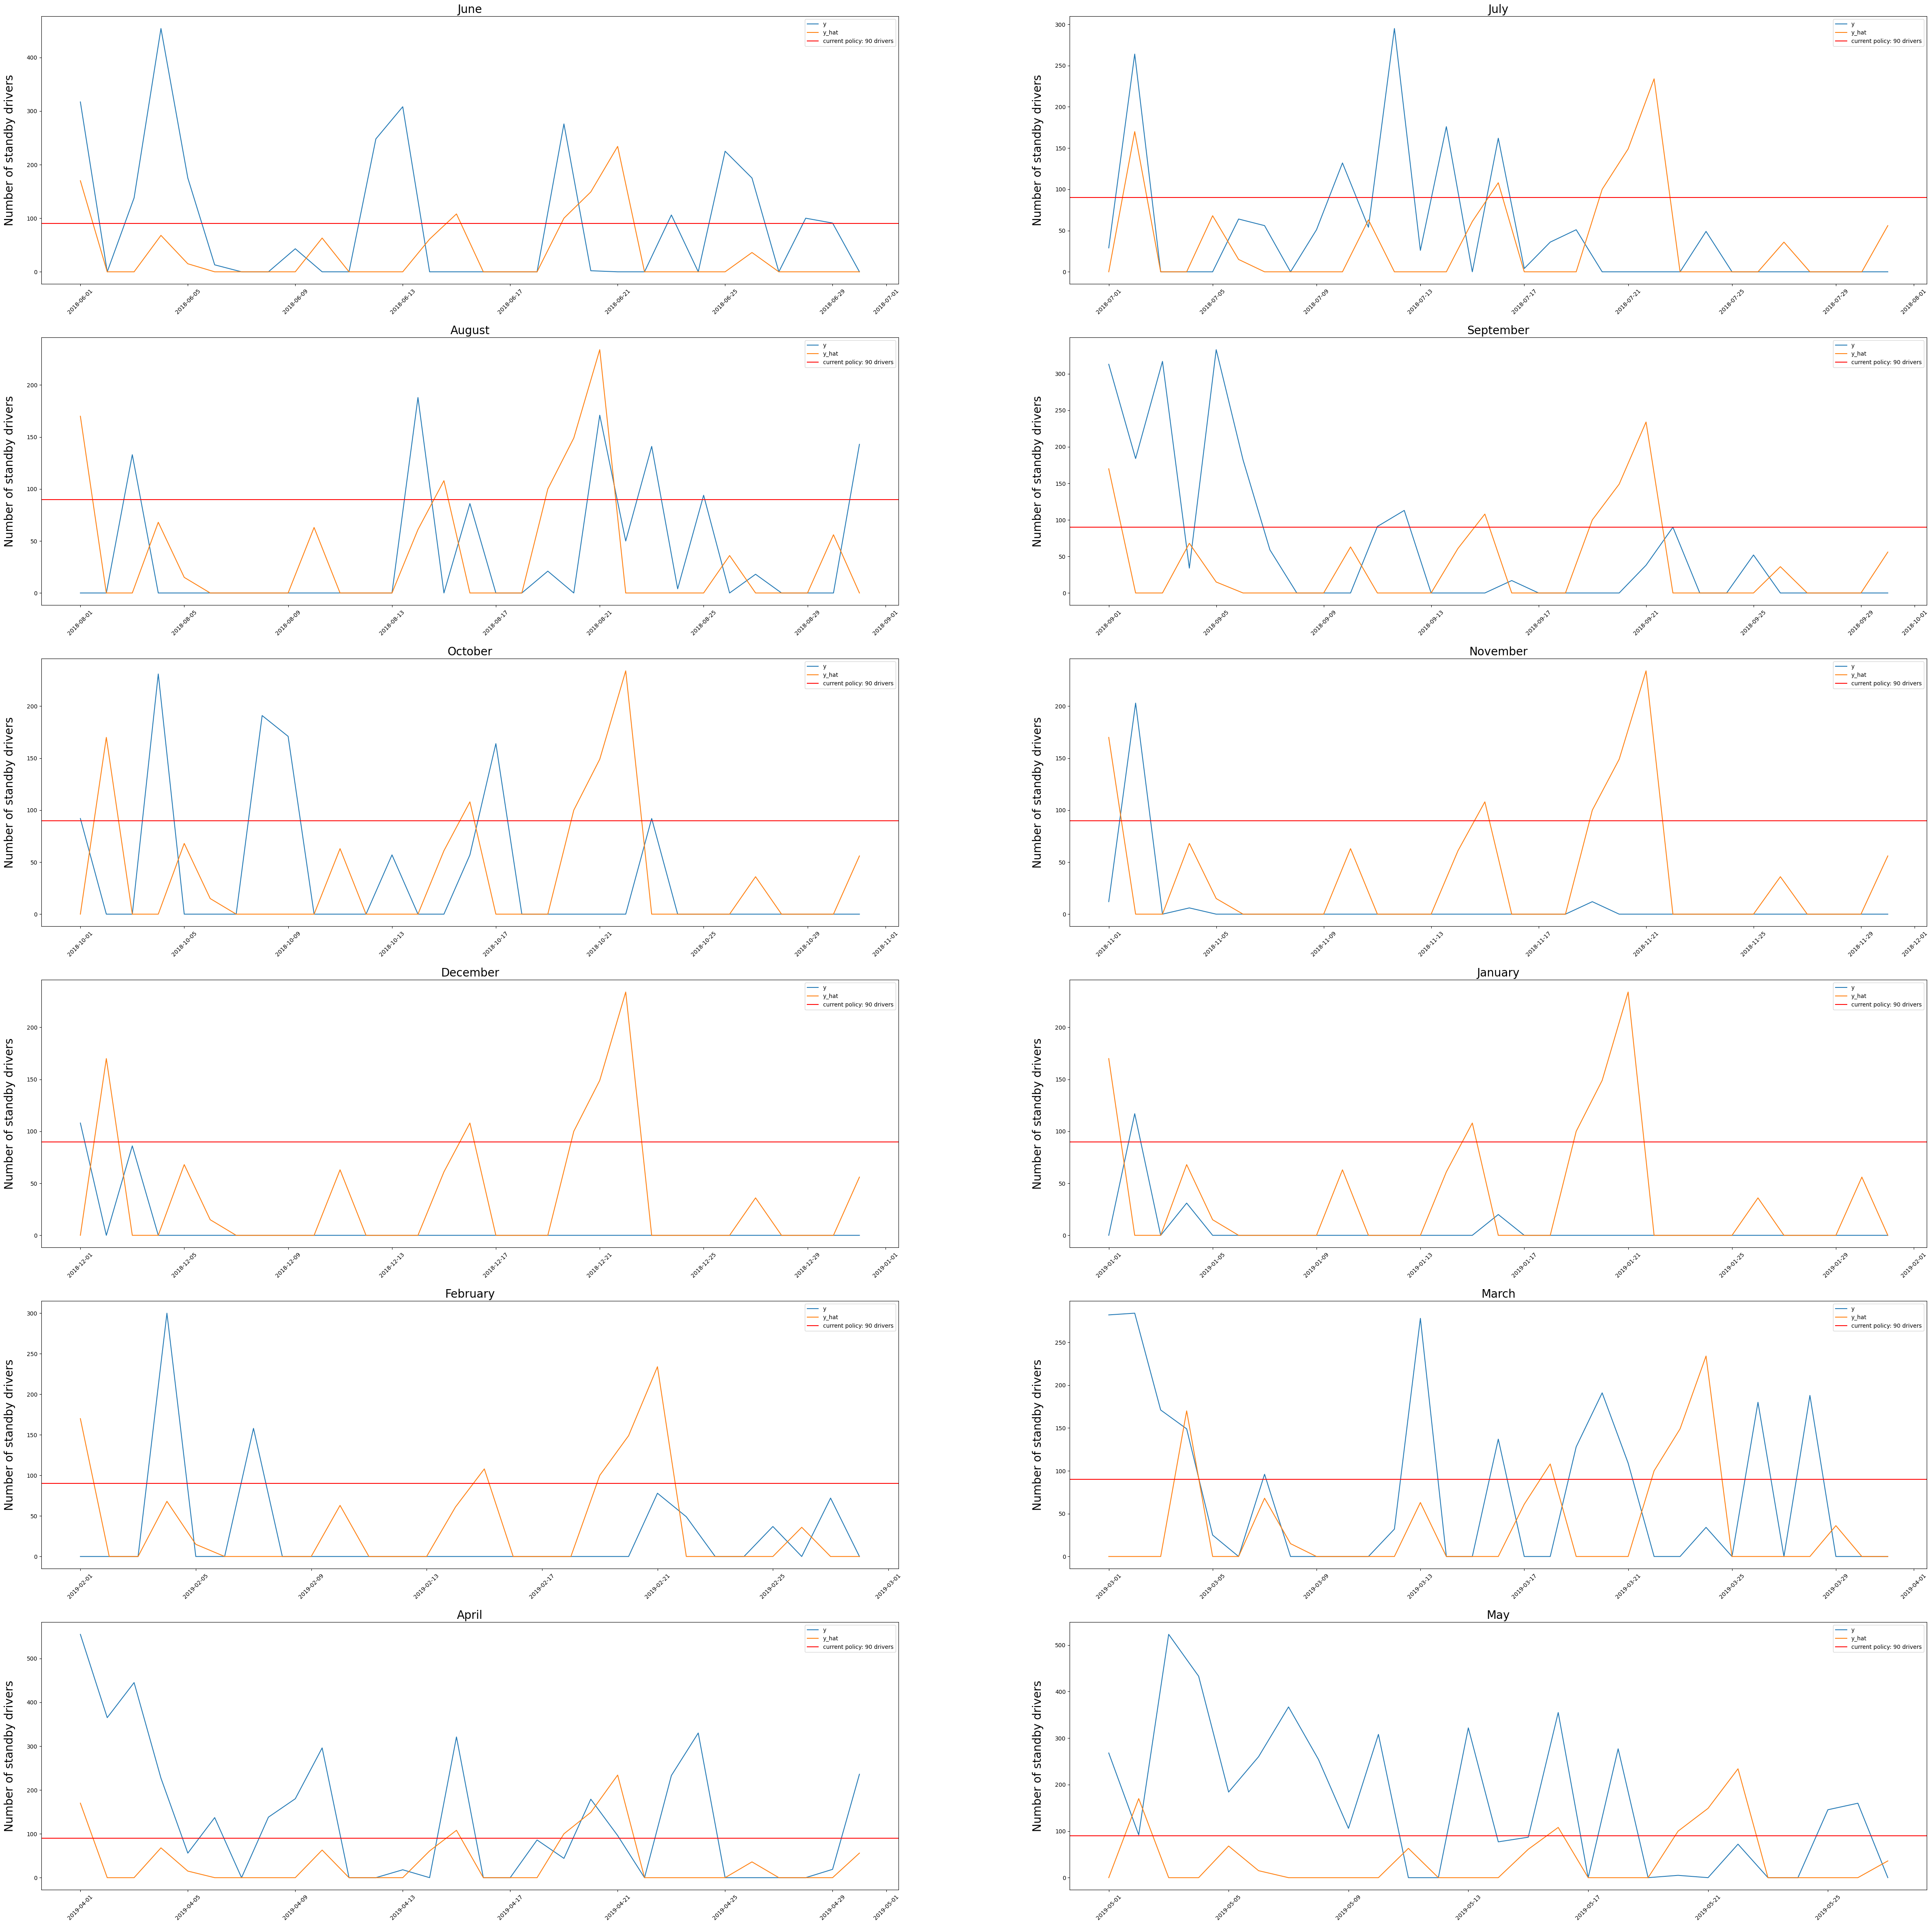

In [30]:
    
cv_model_one_year(model = SeasonalNaive(season_length = 365), 
         statsforecast_df = data, 
         splits_dict = year_split, 
         custom_scorer = interpretable_scores) 

Intriguingly, the baseline naive seasonal forecaster is able to improve the efficiency by 44 %.
However, it also increased the number of additonal underpredictions occurring, thereby violating our second business objective.
Note that when looking at the figure above, it seems that the prediction is highly volatile, where the prediction is zero a lot of the time, yet when it is higher than zero, it is simply too low to meet the sby driver needs most often. 
When testing sktime models later, efforts were undertaken to improve upon the performance of this model by trying to remedy the model's shortcomings.


For now, however, all models developed for intermittent or sparse demand available in the statsforecast were screened.



Split for June
Forecasting for 30 days
Number of leading days: 16
Loss in efficiency = -2.8576245526868718
Number of additional underpredictions = 1
Number of additional sby drivers required when underpredicting = 46.66124226496771

Split for July
Forecasting for 31 days
Number of leading days: 15
Loss in efficiency = -7.387558048475757
Number of additional underpredictions = 1
Number of additional sby drivers required when underpredicting = 6.603132120768237

Split for August
Forecasting for 31 days
Number of leading days: 16
Loss in efficiency = -1.1628283849308865
Number of additional underpredictions = 1
Number of additional sby drivers required when underpredicting = 12.650156293596538

Split for September
Forecasting for 30 days
Number of leading days: 16
Loss in efficiency = -7.324678441584773
Number of additional underpredictions = 4
Number of additional sby drivers required when underpredicting = -3.834051999178797

Split for October
Forecasting for 31 days
Number of leading 

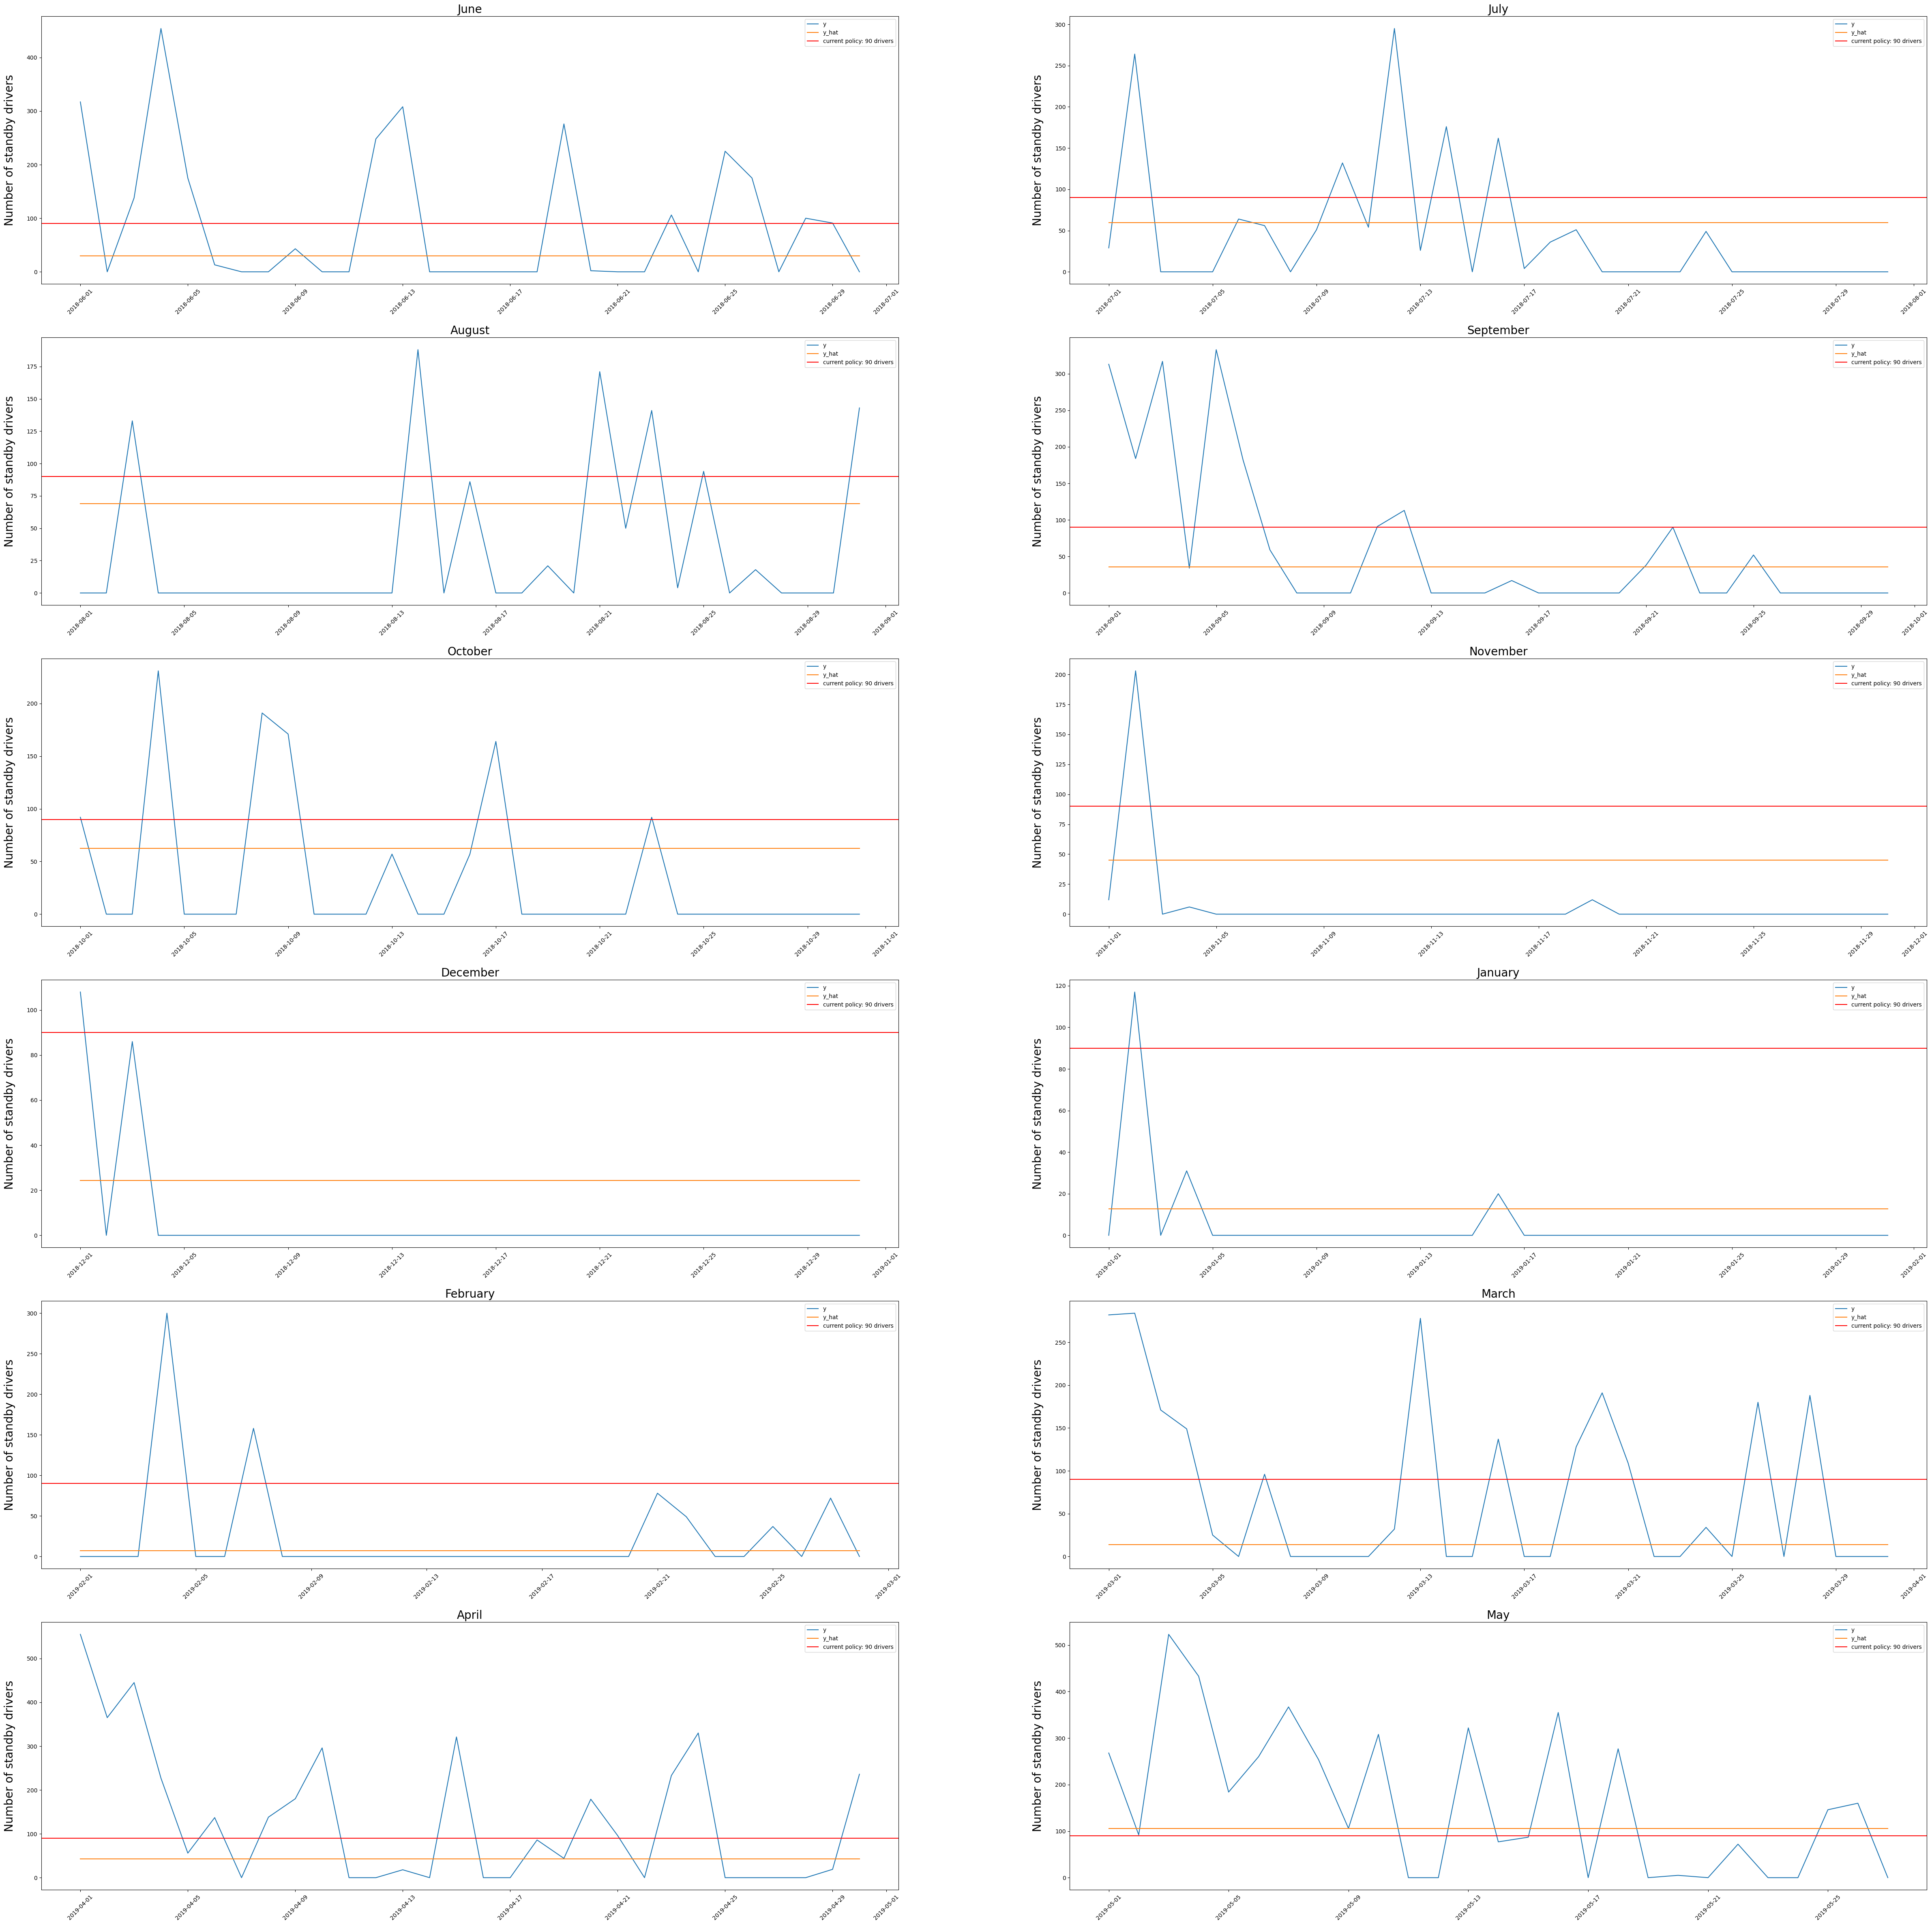

In [31]:
    
cv_model_one_year(model = ADIDA(), 
         statsforecast_df = data, 
         splits_dict = year_split, 
         custom_scorer = interpretable_scores)  


Split for June
Forecasting for 30 days
Number of leading days: 16
Loss in efficiency = -2.8443919491060257
Number of additional underpredictions = 1
Number of additional sby drivers required when underpredicting = 46.42281033442572

Split for July
Forecasting for 31 days
Number of leading days: 15
Loss in efficiency = -5.217815019023401
Number of additional underpredictions = 0
Number of additional sby drivers required when underpredicting = 23.165603637695327

Split for August
Forecasting for 31 days
Number of leading days: 16
Loss in efficiency = -0.8890988080358362
Number of additional underpredictions = 1
Number of additional sby drivers required when underpredicting = 8.025125776018413

Split for September
Forecasting for 30 days
Number of leading days: 16
Loss in efficiency = -7.721632097179011
Number of additional underpredictions = 5
Number of additional sby drivers required when underpredicting = -10.056758880615234

Split for October
Forecasting for 31 days
Number of leading

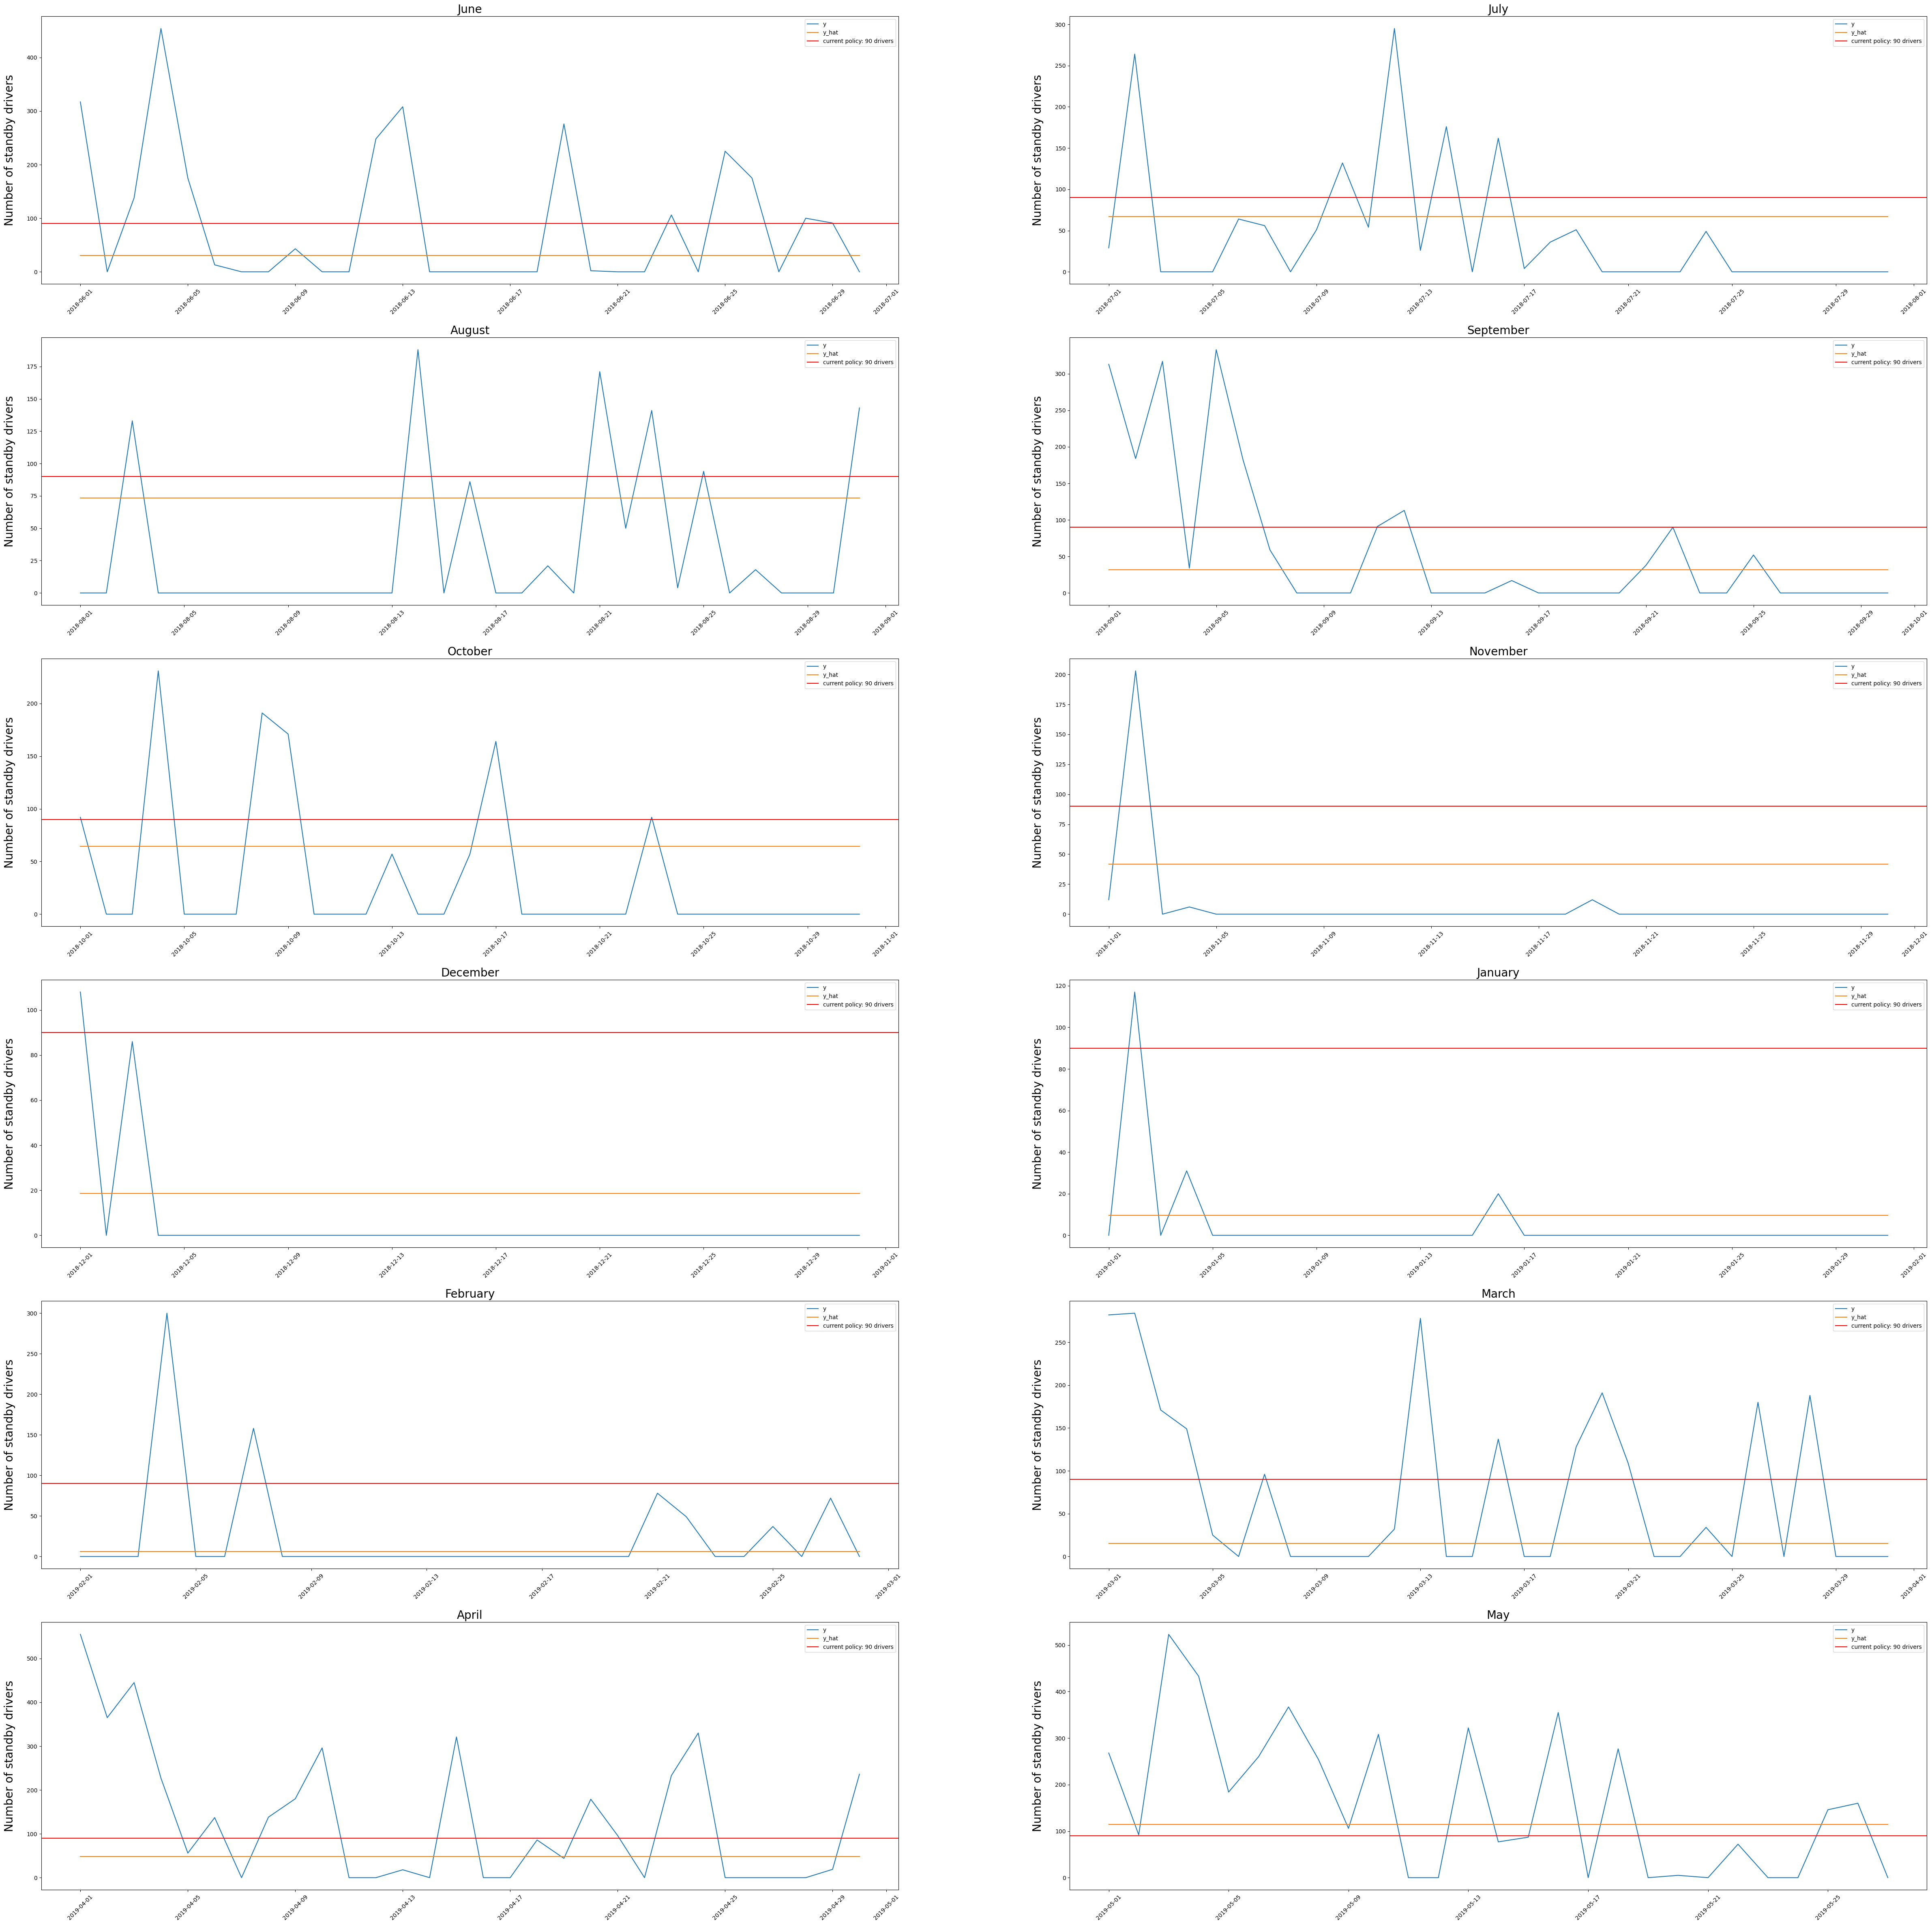

In [32]:
    
cv_model_one_year(model = IMAPA(), 
         statsforecast_df = data, 
         splits_dict = year_split, 
         custom_scorer = interpretable_scores)  


Split for June
Forecasting for 30 days
Number of leading days: 16
Loss in efficiency = -3.3790982280812543
Number of additional underpredictions = 1
Number of additional sby drivers required when underpredicting = 53.76736332820013

Split for July
Forecasting for 31 days
Number of leading days: 15
Loss in efficiency = -3.9567309313310624
Number of additional underpredictions = 0
Number of additional sby drivers required when underpredicting = 18.732063293457045

Split for August
Forecasting for 31 days
Number of leading days: 16
Loss in efficiency = -0.16031025581776248
Number of additional underpredictions = 0
Number of additional sby drivers required when underpredicting = 2.194000244140625

Split for September
Forecasting for 30 days
Number of leading days: 16
Loss in efficiency = -8.862974515847696
Number of additional underpredictions = 5
Number of additional sby drivers required when underpredicting = 2.2062549591064453

Split for October
Forecasting for 31 days
Number of leadin

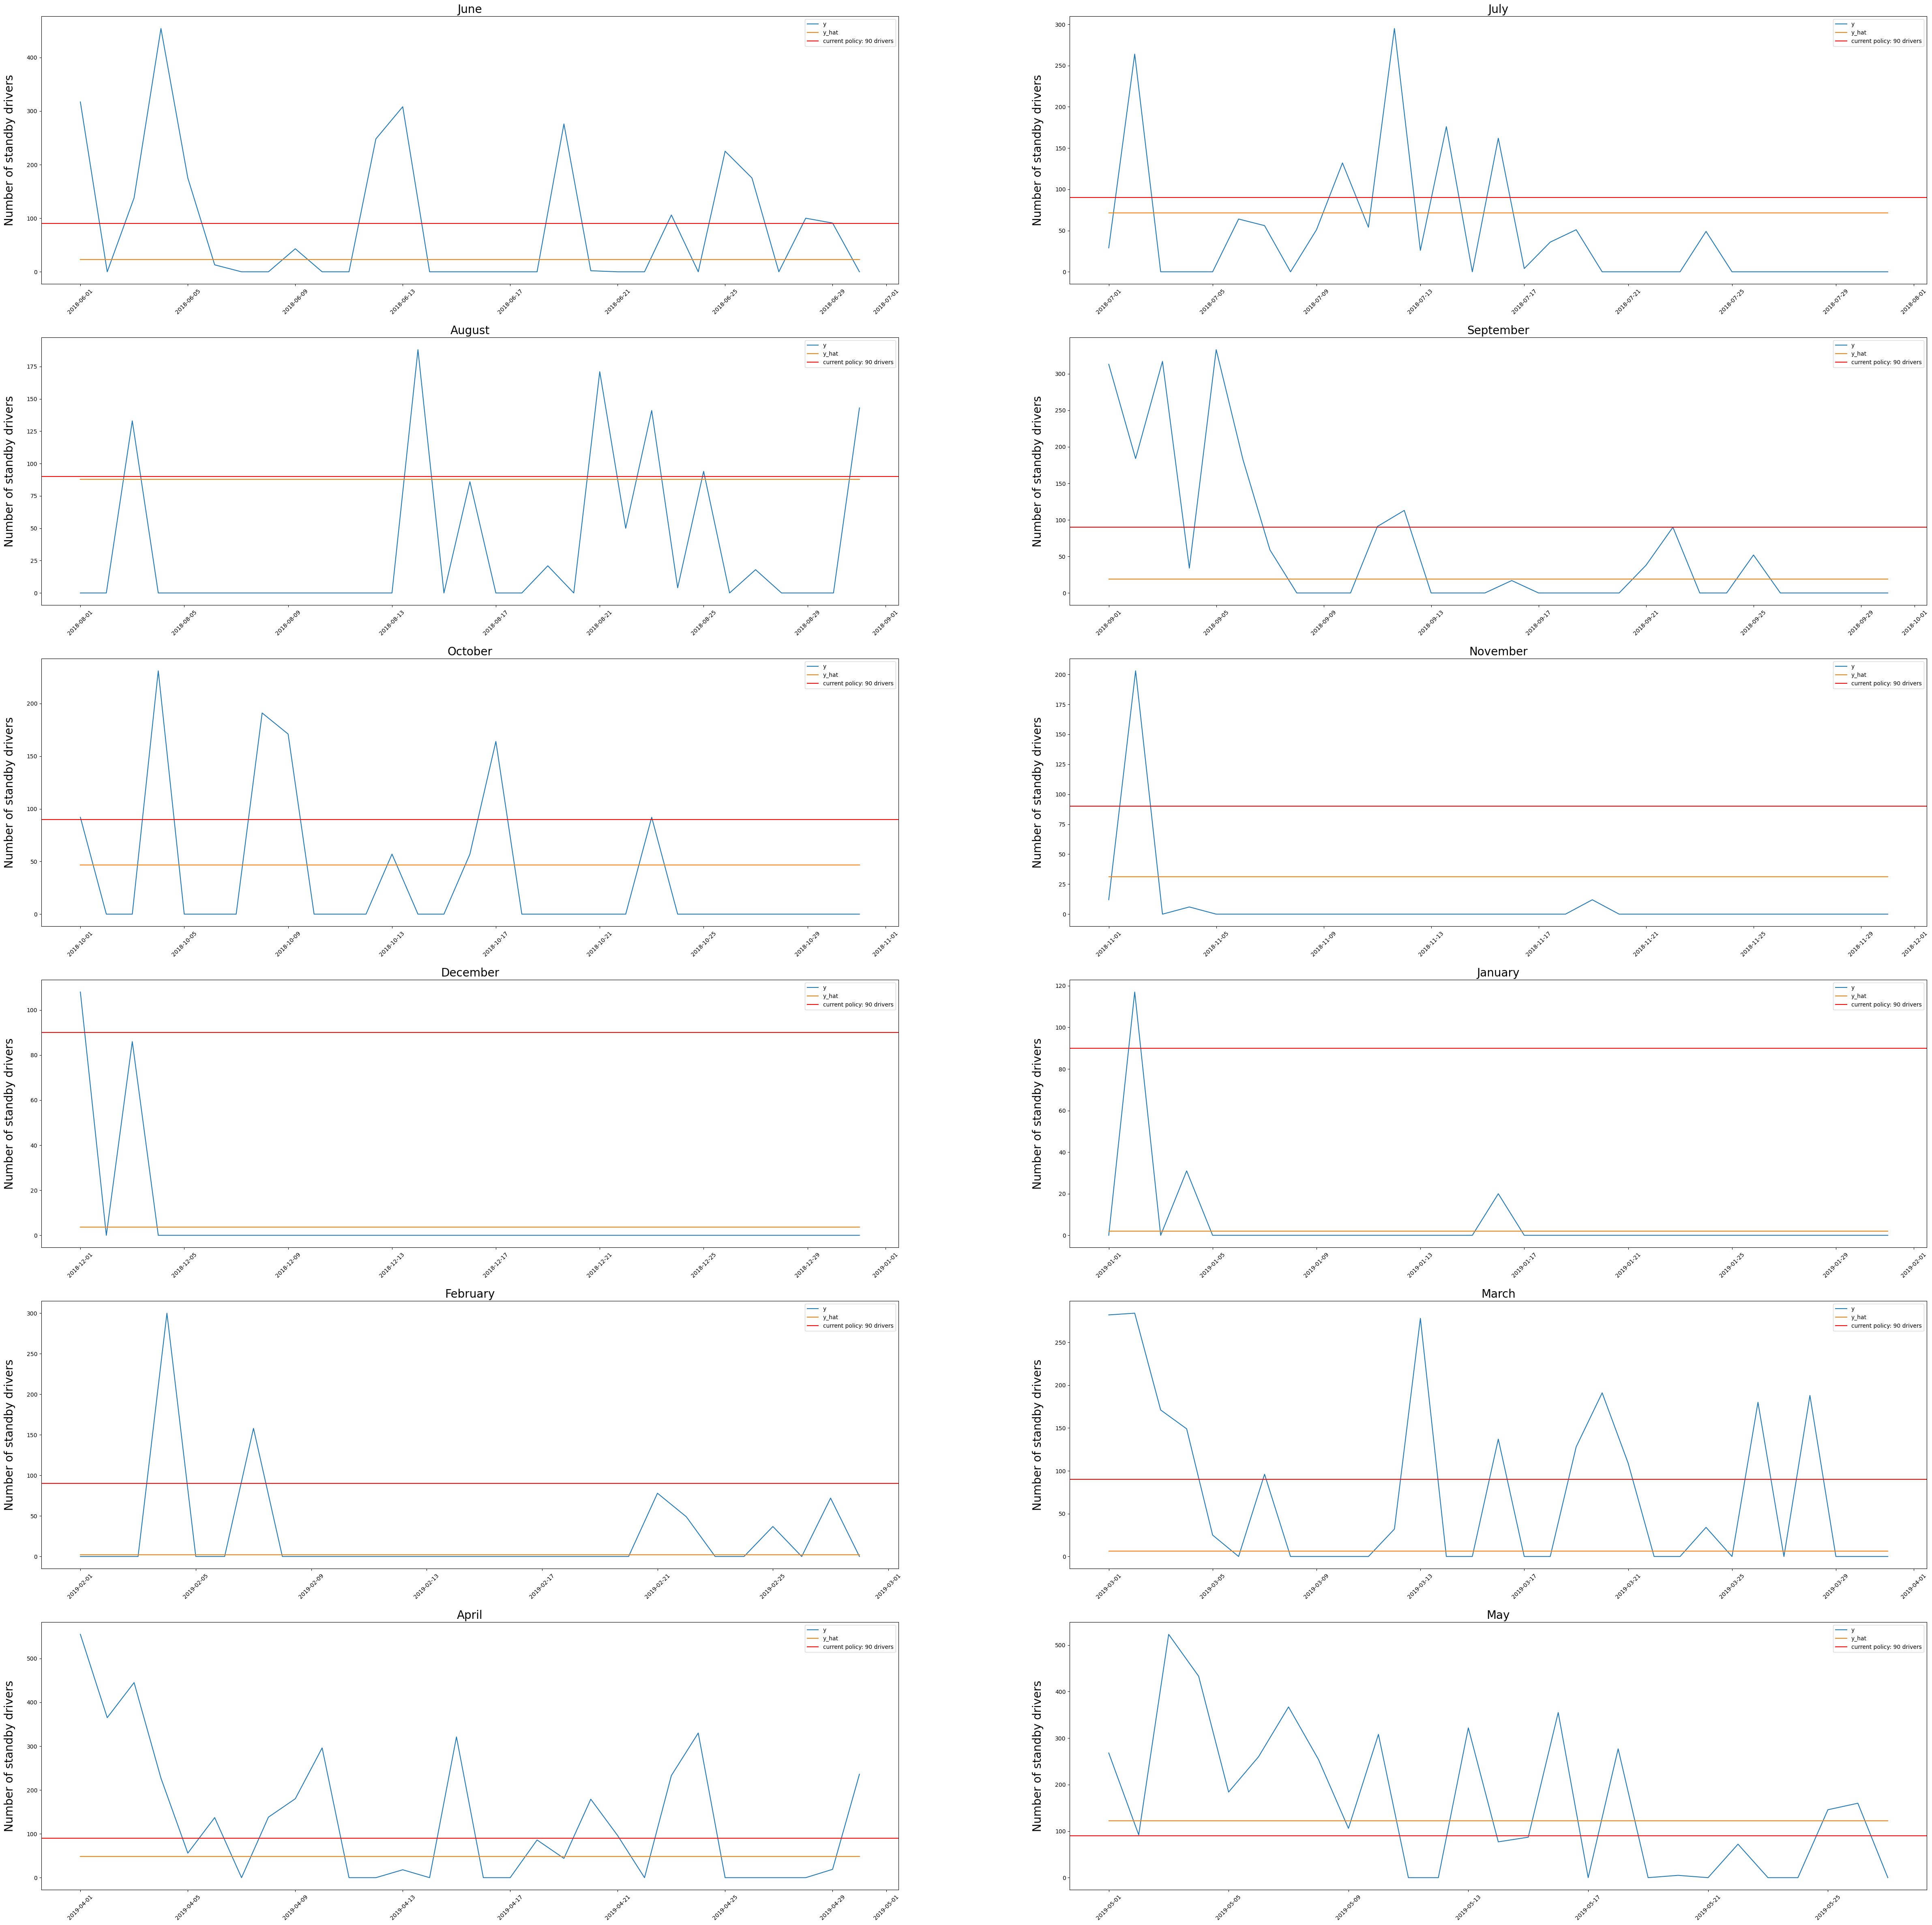

In [33]:
    
cv_model_one_year(model = TSB(alpha_d=0.2, alpha_p=0.2), 
         statsforecast_df = data, 
         splits_dict = year_split, 
         custom_scorer = interpretable_scores)  


Split for June
Forecasting for 30 days
Number of leading days: 16
Loss in efficiency = 1.2624201296905895
Number of additional underpredictions = -3
Number of additional sby drivers required when underpredicting = 20.87830861409506

Split for July
Forecasting for 31 days
Number of leading days: 15
Loss in efficiency = 7.561354254169363
Number of additional underpredictions = -2
Number of additional sby drivers required when underpredicting = -35.97657470703125

Split for August
Forecasting for 31 days
Number of leading days: 16
Loss in efficiency = 2.8709612657362342
Number of additional underpredictions = -1
Number of additional sby drivers required when underpredicting = -29.868695068359376

Split for September
Forecasting for 30 days
Number of leading days: 16
Loss in efficiency = 2.7222054714643384
Number of additional underpredictions = -1
Number of additional sby drivers required when underpredicting = -0.5425211588541572

Split for October
Forecasting for 31 days
Number of lead

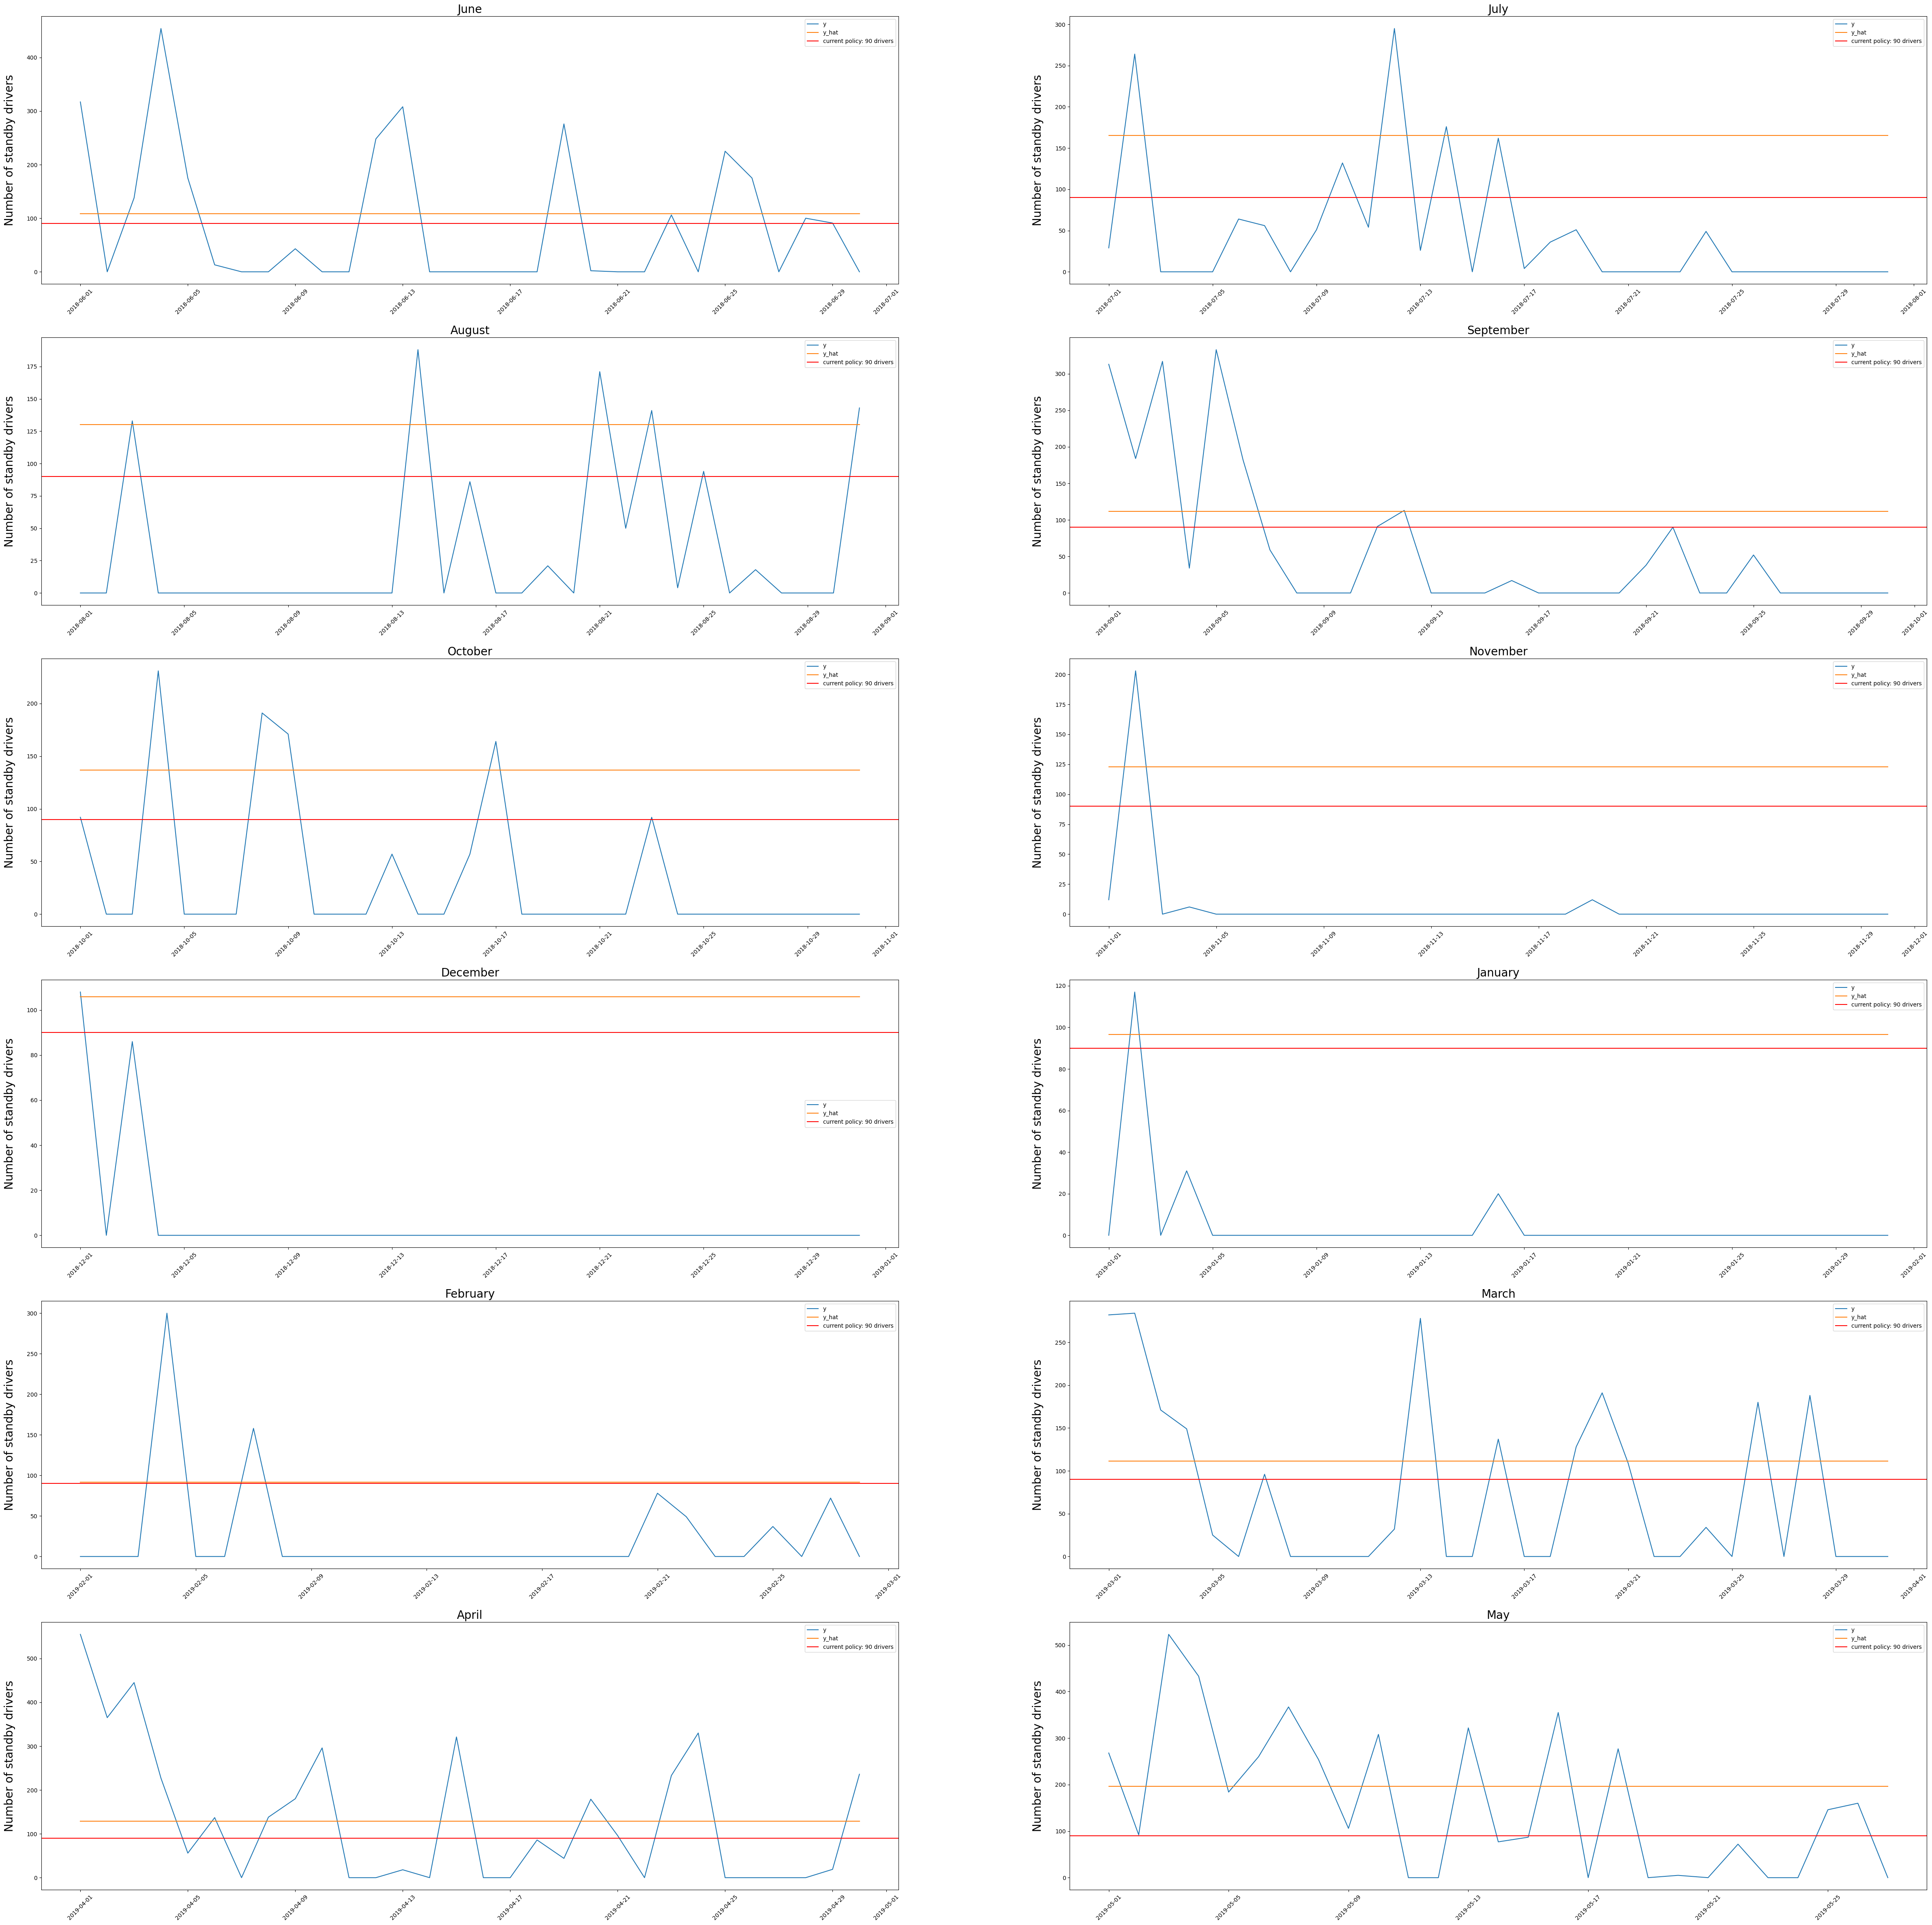

In [34]:
    
cv_model_one_year(model = CrostonClassic(), 
         statsforecast_df = data, 
         splits_dict = year_split, 
         custom_scorer = interpretable_scores)  


Split for June
Forecasting for 30 days
Number of leading days: 16
Loss in efficiency = 1.5042409145049973
Number of additional underpredictions = -3
Number of additional sby drivers required when underpredicting = 18.408620198567718

Split for July
Forecasting for 31 days
Number of leading days: 15
Loss in efficiency = 9.584602696351173
Number of additional underpredictions = -3
Number of additional sby drivers required when underpredicting = -25.84560852050781

Split for August
Forecasting for 31 days
Number of leading days: 16
Loss in efficiency = 2.722938514985504
Number of additional underpredictions = -1
Number of additional sby drivers required when underpredicting = -27.085903930664063

Split for September
Forecasting for 30 days
Number of leading days: 16
Loss in efficiency = 2.327778595413154
Number of additional underpredictions = -1
Number of additional sby drivers required when underpredicting = 3.214139302571624

Split for October
Forecasting for 31 days
Number of leading

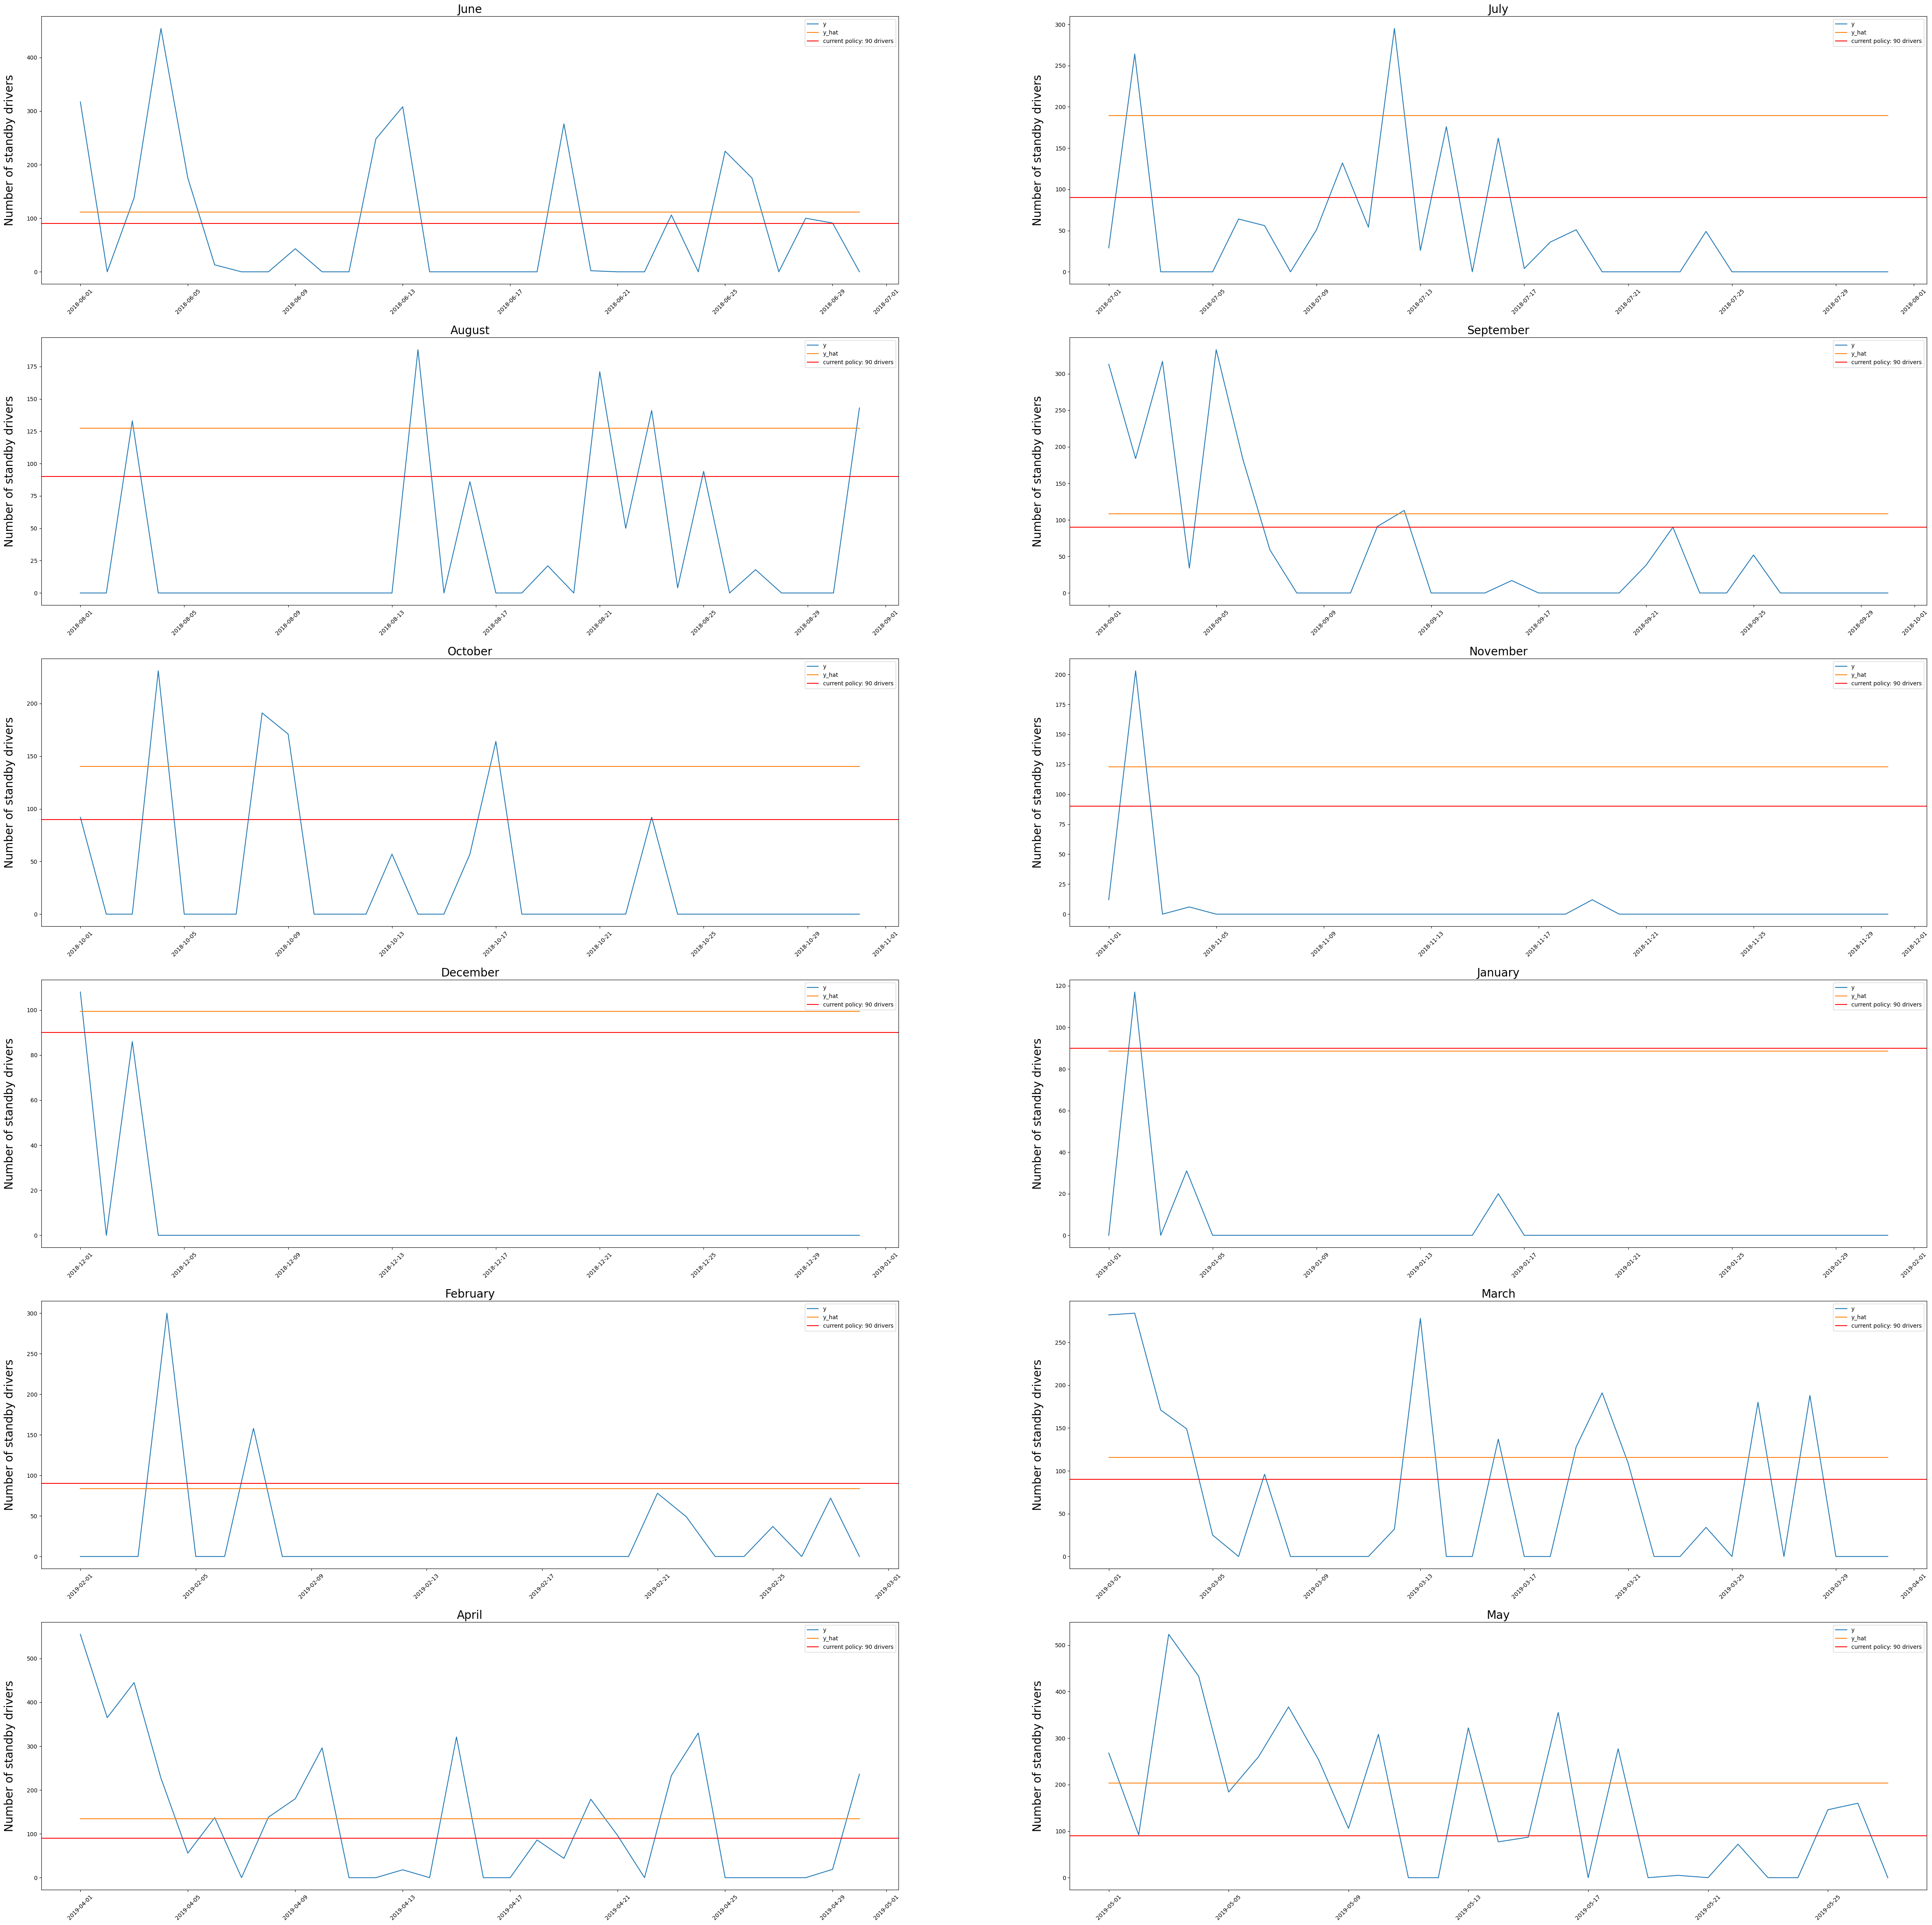

In [35]:
cv_model_one_year(model = CrostonOptimized(), 
         statsforecast_df = data, 
         splits_dict = year_split, 
         custom_scorer = interpretable_scores)  


Split for June
Forecasting for 30 days
Number of leading days: 16
Loss in efficiency = 0.7776132535596574
Number of additional underpredictions = -2
Number of additional sby drivers required when underpredicting = 11.180224609374989

Split for July
Forecasting for 31 days
Number of leading days: 15
Loss in efficiency = 6.931935375264619
Number of additional underpredictions = -1
Number of additional sby drivers required when underpredicting = -48.46773986816406

Split for August
Forecasting for 31 days
Number of leading days: 16
Loss in efficiency = 2.514613153998326
Number of additional underpredictions = -1
Number of additional sby drivers required when underpredicting = -23.365261840820313

Split for September
Forecasting for 30 days
Number of leading days: 16
Loss in efficiency = 2.124738359795547
Number of additional underpredictions = -1
Number of additional sby drivers required when underpredicting = 5.05127461751303

Split for October
Forecasting for 31 days
Number of leading 

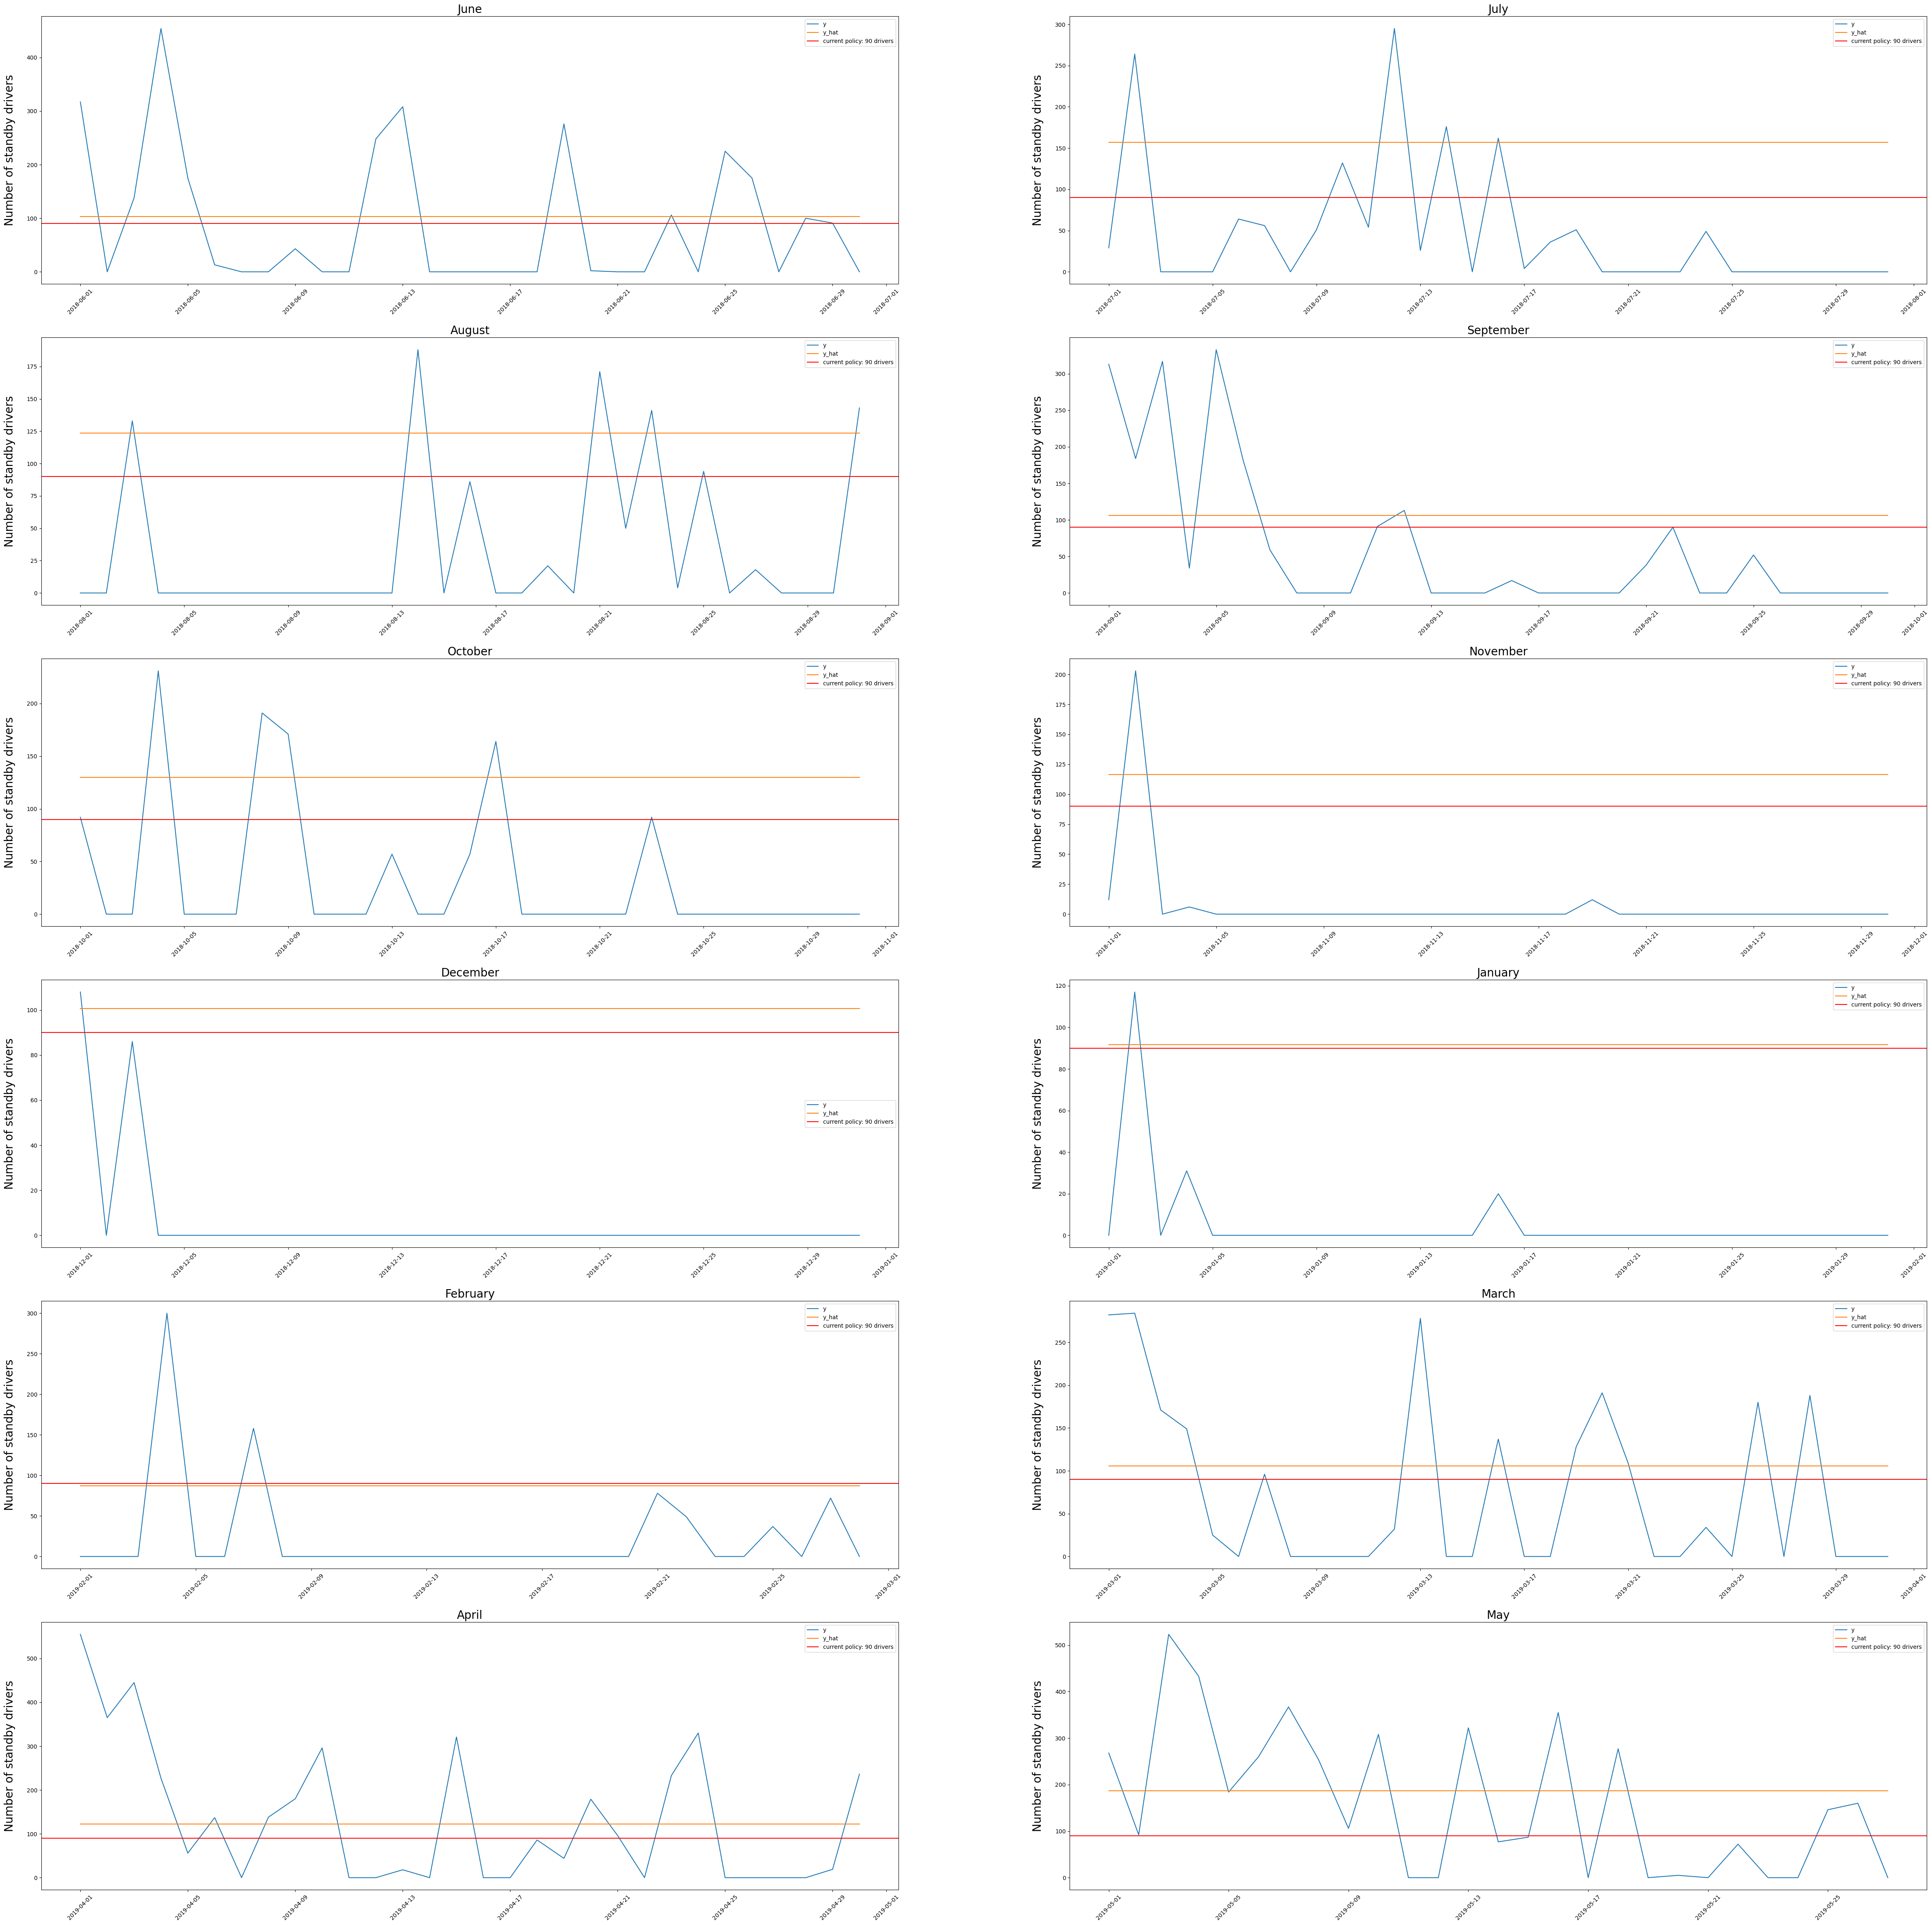

In [36]:
cv_model_one_year(model = CrostonSBA(), 
         statsforecast_df = data, 
         splits_dict = year_split, 
         custom_scorer = interpretable_scores)  

Notably, none of the more sophisticated models was able to beat the naive baseline model.

Afterwards, attempts were made to improve the performance of the more sophisticated models by applying moving average smoothing of the initial time series, using different smoothing windows (smoothed by one day, one week, one month).
Furthermore, the data was power transformed using box cox transformations or log transformations, respectively, to test its influence on prediction performance.
Moreover, combinations of smoothing and power transformations were tested as well.
However, none of those approaches lead to improvements worth noting when judged by the business metrics.

Honestly, the notebooks in which the testing of those approaches was performed look like a mess and the code therein would require a considerable amount of further time investment to make it at least somehow presentable.
Thus, for the time being I will not make it publicly available, especially as there is no real point to it as the model performance could not be improved substantially.

Lastly, what is notable about the intermittent demand models is that they predict a constant value for the forecasting horizon, which may be one of the reasons for their bad performance for this use case as they fail to reduce the number of predicted sby driver needs to the end of each month to account for the pattern of sby driver requirements observed during EDA.

In conclusion, as the statsforecast models were not satisfying business goals, I moved on to models available in other python packages.
The story continues in sktime_modeling.
